In [2]:
import sys
sys.path.insert(0, "/home/spiffical/data/spiffical/")
import os
import numpy as np
import h5py
import vos
import pickle
import random
import scipy.signal as spsi
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import json
from StarNet.nn.utilities.data_augmentation import continuum_normalize, mask_tellurics, add_zeros, convolve_spectrum
from StarNet.gaiaESO.plotting import plot_compare_estimates_resid
from StarNet.nn.utilities.load_data import load_data_from_h5 
from keras.models import load_model
from astropy.io import ascii
from astropy.io import fits as pyfits
from pysynphot import observation
from pysynphot import spectrum
from scipy.ndimage.filters import gaussian_filter

In [3]:
plt.rcParams['axes.grid']=True
plt.rcParams['grid.color']='gray'
plt.rcParams['grid.alpha']='0.4'
plt.rcParams["text.usetex"] = True

## Define folder names

In [106]:
mu_std_folder = '/home/spiffical/data/spiffical/gaia-ESO/' 
intrigoss_spectra_folder = '/spiffical/spectra/preprocessed/intrigoss/' 
starnet_data_folder = '/home/spiffical/data/spiffical/StarNet/gaiaESO/data/'
#model_folder = 'StarNet_2018-10-31_run1/'#StarNet_2018-07-27_run1/'#'StarNet_2018-11-05_run1/'#'StarNet_2018-10-05_run1/'##'StarNet_2018-07-27_run1/' #
#model_folder = 'StarNet_2018-11-23_run1/' # This one was trained with no noise added to the spectra
#model_folder = 'Runs/intrigoss_uves_vrad200_vrot70_2'
#model_folder = 'Runs/intrigoss_uves_vrad0_vrot0'
#model_folder = 'Runs/intrigoss_uves_vrad5_vrot70_4labels'
model_folder = 'Runs/intrigoss_uves_vrad5_vrot70_statcont/'

## Load trained model

In [103]:
#model_path = model_folder+'model_weights.h5'
model_path = os.path.join(model_folder, 'weights.best.h5')
model = load_model(model_path)

#### Collect info from model parameter file...

In [127]:
model_parameter_filepath = os.path.join(model_folder, 'model_parameter.json')
if os.path.exists(model_parameter_filepath):
    with open(model_parameter_filepath, 'r') as f:
        
        datastore = json.load(f)
        
        print('Acquiring mu and sigma from model parameter file...')
        mu = np.asarray(datastore['mu'])
        sigma = np.asarray(datastore['sigma'])
        print('mu: {}'.format(mu))
        print('sigma: {}'.format(sigma))
        
        print('\nAcquiring target names...')
        targets = datastore['targetname']
        print('targets: {}'.format(targets))
        
        print('\nAcquiring h5py key for spectra...')
        spec_name = datastore['spec_key']
        print('spectrum key: {}'.format(spec_name))

Acquiring mu and sigma from model parameter file...
mu: [ 5.34085278e+03  2.84011944e+00 -2.50209722e-01  1.24120833e-01]
sigma: [1.00370249e+03 1.40102765e+00 5.00010720e-01 2.78265819e-01]

Acquiring target names...
targets: [u'teff', u'logg', u'M_H', u'a_M']

Acquiring h5py key for spectra...
spectrum key: spectra_statcont


In [13]:
def denormalize(data, mu, sigma):
    
    return ((data*sigma)+mu)

## Load INTRIGOSS test dataset

In [128]:
#mu_std = mu_std_folder+'mu_std_INTRIGOSS_gaiaeso_UVES-4835-5395_7labels.txt'
#targets = ['teff', 'logg', 'M_H', 'a_M', 'v_rot', 'v_rad', 'VT']
#spec_name = 'spectra_starnetnorm'
#data_file = infolder_synth + 'INTRIGOSS_gaiaeso_UVES-4835-5395_7labels_fixed.h5'
#data_file = os.path.join(intrigoss_spectra_folder, 'INTRIGOSS_gaiaeso_UVES-4835-5395_7labels_testset.h5')
data_filename = 'INTRIGOSS_UVES-4835-5395_vrad5_vrot70_train.h5'
data_file = os.path.join(intrigoss_spectra_folder, data_filename)

#indexes = np.arange(260000,265000,1)
indexes = np.arange(0,9000,1)
data = load_data_from_h5(data_file=data_file,
                         indices=indexes,
                         targetname=targets,
                         mu_std=None,
                         specname=spec_name)

X_synth, y_synth, noise_synth, wave_grid = data.X, data.y, data.noise, data.wave_grid

# Mask telluric lines
X_synth = mask_tellurics(os.path.join(starnet_data_folder, 'telluric_lines.txt'), X_synth, wave_grid)

# Zero-point bad values
for x in X_synth:
    x[x>1.03]=0
    x[x<0]=0

# Add zeros
#X_synth = add_zeros(X_synth, 1500)

In [12]:
# Only test on spectra of certain S/N?
indices = np.where(np.asarray(noise_synth) < 0.07)[0]
X_synth = X_synth[indices]
y_synth = y_synth[indices]
noise_synth = np.asarray(noise_synth)[indices]

## Tests on INTRIGOSS dataset

In [129]:
# Reshape data for compatibility with neural network
X = np.reshape(X_synth, (np.shape(X_synth)[0], np.shape(X_synth)[1], 1))

# Predict on synthetic spectra
test_pred = model.predict(X, batch_size=5, verbose=0)
test_pred_synth = denormalize(test_pred, mu, sigma)
test_labels_synth_denorm = y_synth

<IPython.core.display.Javascript object>


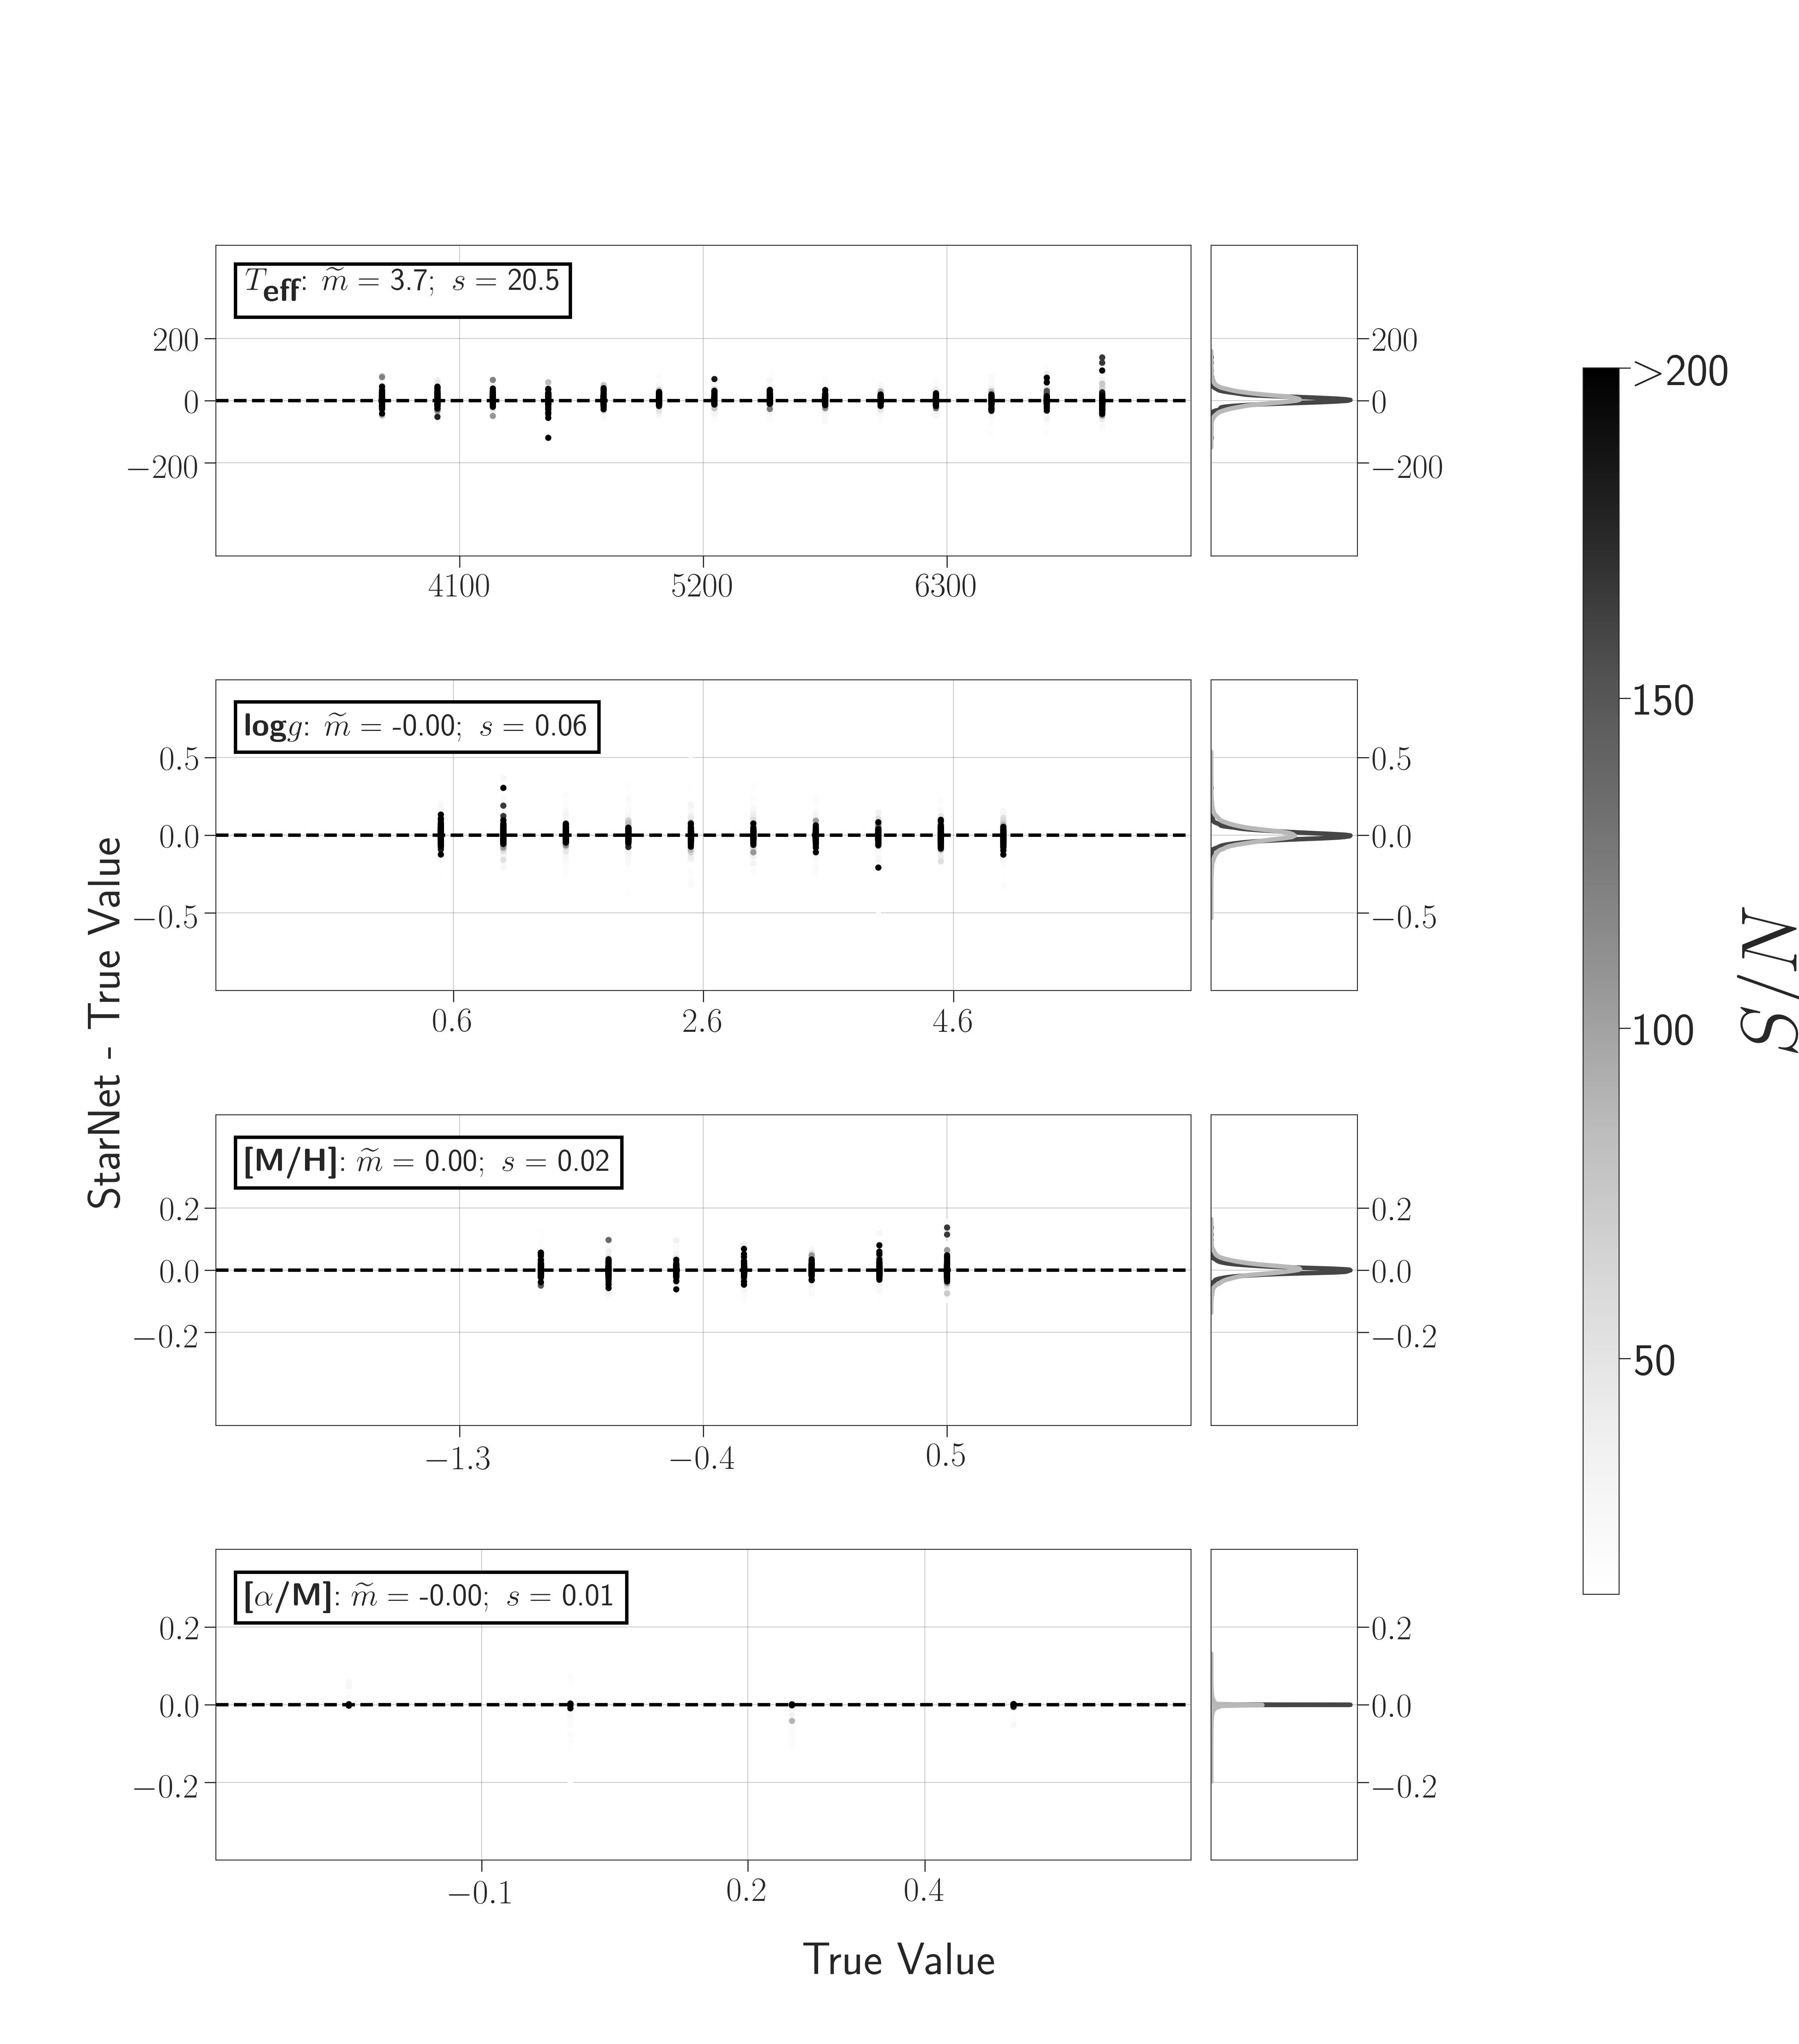

In [89]:
all_targets = test_labels_synth_denorm
all_pred = test_pred_synth
z = np.divide(1, noise_synth)
snr_max=200
label_names = [r'$T_{\textbf{eff}}$',r'log$g$',r'[M/H]',r'[$\alpha$/M]',r'$v_{\textbf{rot}}$',r'$v_\textbf{{rad}}$',r'v$_\textbf{{micro}}$']
x_lab=r'True Value'
y_lab=r'StarNet - True Value'
cmap = 'Greys'
lims = [[3000., 7400.], [-1.3, 6.5], [-2.2, 1.4],
        [-0.4, 0.7], [-10, 75.], [-220, 220.], [0, 3]]
resid_lims = [[-500., 500.], [-1, 1], [-0.5, 0.5],
              [-0.4, 0.4], [-20, 20], [-50, 50], [-1, 1]]

plot_compare_estimates_resid(x_data=all_targets, 
                             y_data=all_pred, 
                             snr=z, 
                             savename=None, 
                             x_lab=x_lab, 
                             y_lab=y_lab, 
                             snr_max=snr_max, 
                             cmap=cmap,
                             label_names=label_names,
                             lims=lims,
                             resid_lims=resid_lims,
                             indx=4)

In [20]:
from pylab import setp

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    
    setp(bp['boxes'][1], color='magenta', alpha=0.4)
    setp(bp['caps'][2], color='magenta', alpha=0.4)
    setp(bp['caps'][3], color='magenta', alpha=0.4)
    setp(bp['whiskers'][2], color='magenta', alpha=0.4)
    setp(bp['whiskers'][3], color='magenta', alpha=0.4)
    setp(bp['medians'][1], color='magenta', alpha=0.4)
    
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
    setp(bp['medians'][0], color='blue')
    
    # fill with colors
    colors = ['lightblue', 'pink']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

In [21]:
def make_boxplots(targets, SNR, difference, high_SNR, low_SNR, 
                  bin_centers, bin_width=[100,0.25], 
                  xlims=[0,22], ylims=[-250,250],
                  labels=[r'T$_{eff}$', r'log$g$', r'[M/H]'],
                  xlabel='',
                  ylabel=''):

    # Statistics
    bias = np.nanmedian(difference, axis=0)
    scatter = np.nanstd(difference, axis=0)
    
    numPlots = targets.shape[1]
    fig, axes = plt.subplots(numPlots, 1, figsize=(8, numPlots*1.5))
    
    for i in range(numPlots):
        bins = []
        for center in bin_centers[i]:
            inds1 = np.logical_and(abs(targets[:,i] - center) < bin_width[i], SNR>high_SNR) 
            inds2 = np.logical_and(abs(targets[:,i] - center) < bin_width[i], SNR<low_SNR)
            bins.append([difference[:,i][inds1],
                         difference[:,i][inds2]])
        

        for j in range(len(bins)):
            # Find the smallest bin, get number of elements in it so we can ensure every bin has
            # the same number of elements. Then plot each boxplot.
            min_bin = min([min(len(binnn[0]),len(binnn[1])) for binnn in bins])
            np.random.shuffle(bins[j][0])
            np.random.shuffle(bins[j][1])
            new_bins1 = bins[j][0][:min_bin]
            new_bins2 = bins[j][1][:min_bin]
            bp = axes[i].boxplot([new_bins1,new_bins2], showfliers=False,
                                 positions = [3*j+1.5,3*j+1.5], widths = [2.4,2.6],
                                 patch_artist=True,
                                 notch=True)
            setBoxColors(bp)
        
        # set axes limits and labels
        axes[i].set_xlim(xlims[i][0],xlims[i][1])
        axes[i].set_ylim(ylims[i][0],ylims[i][1])
        axes[i].set_xticklabels(centers[i])
        axes[i].set_xticks([j*3+1.5 for j in range(len(bins))])
        axes[i].axhline(y=0.0, color='black', linestyle='--', alpha=0.4)
        #axes[i].set_xlabel('ASPCAP', fontsize=12)
        #axes[i].set_ylabel('', fontsize=12)
        
        # Annotate median and std of residuals
        bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=1)
        axes[i].annotate(r'\textbf{{{}}}:  '.format(labels[i]) + '$\widetilde{{m}}=${0:6.2f}$;\ s =${1:6.2f}'.format(bias[i],scatter[i],width=6), 
                         xy=(0.05, 0.12), xycoords='axes fraction', fontsize=10, bbox=bbox_props)
        
        # annotate plots
        #bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=1)
        #annotation = labels[i]
        #axes[i].annotate(annotation, xy=(0.05, 0.12), xycoords='axes fraction', fontsize=9, bbox=bbox_props)
        
        axes[i].grid(False)

        # draw temporary red and blue lines and use them to create a legend
        hB, = axes[i].plot([0,0],'b-')
        hR, = axes[i].plot([0,0],'m-')
        if i != numPlots - 1:
            hB.set_visible(False)
            hR.set_visible(False)
    
    # Set x and y figure labels
    fig.text(0.02, 0.5, ylabel, ha='center', va='center', 
             rotation='vertical', fontsize=15)
    fig.text(0.5, 0.01, xlabel, ha='center', va='center',
             fontsize=15)
    
    # Set figure legend
    fig.legend((hB, hR), (r'S/N $>$ %s' % high_SNR, r'S/N $<$ %s' % low_SNR), 'upper center', ncol=2,
              framealpha=1.0)
    
    fig.subplots_adjust(wspace=.01, hspace=.3)
    fig.subplots_adjust(right=0.9, left=0.095, bottom=0.06, top=0.95)
    
    #fig.tight_layout()
    plt.show()

In [156]:
def make_boxplots_two_datasets(xdata, ydata1, ydata2, 
                               bin_centers, bin_width=[100,0.25], 
                               xlims=[0,22], ylims=[-250,250],
                               labels=[r'T$_{eff}$', r'log$g$', r'[M/H]'],
                               xlabel='',
                               ylabel='',
                               legend=('', '')):

    # Statistics
    #bias = np.nanmedian(difference, axis=0)
    #scatter = np.nanstd(difference, axis=0)
    
    numPlots = ydata1.shape[1]
    fig, axes = plt.subplots(numPlots/2, 2, figsize=(14, numPlots*1.2))
    axes = axes.ravel()
    
    for i in range(numPlots):
        bins = []
        for center in bin_centers[i]:
            inds1 = np.array(abs(xdata[:,i] - center) < bin_width[i])
            inds2 = np.array(abs(xdata[:,i] - center) < bin_width[i])
            bins.append([ydata1[:,i][inds1],
                         ydata2[:,i][inds2]])
        
        for j in range(len(bins)):
            # Find the smallest bin, get number of elements in it so we can ensure every bin has
            # the same number of elements. Then plot each boxplot.
            min_bin = min([min(len(binnn[0]),len(binnn[1])) for binnn in bins])
            np.random.shuffle(bins[j][0])
            np.random.shuffle(bins[j][1])
            new_bins1 = bins[j][0][:min_bin]
            new_bins2 = bins[j][1][:min_bin]
            bp = axes[i].boxplot([new_bins1,new_bins2], showfliers=False,
                                 positions = [3*j+1.5,3*j+1.5], widths = [2.4,2.6],
                                 patch_artist=True,
                                 notch=True,
                                 zorder=1)
            setBoxColors(bp)
        
        # set axes limits and labels
        axes[i].set_xlim(xlims[i][0],xlims[i][1])
        axes[i].set_ylim(ylims[i][0],ylims[i][1])
        axes[i].set_xticklabels(centers[i])
        axes[i].set_xticks([j*3+1.5 for j in range(len(bins))])
        axes[i].xaxis.set_tick_params(labelsize=13)
        if i==0:
            for label in axes[i].xaxis.get_ticklabels()[::2]:
                label.set_visible(False)
        axes[i].yaxis.set_tick_params(labelsize=13)
        axes[i].axhline(y=0.0, color='black', linestyle='--', alpha=1.0, lw=3, zorder=2)
        #plt.axhline(y=0, color='r', linestyle=':')
        
        # Annotate median and std of residuals
        #bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=1)
        #axes[i].annotate(r'\textbf{{{}}}:  '.format(labels[i]) + '$\widetilde{{m}}=${0:6.1f}$;\ s =${1:6.1f}'.format(bias[i],scatter[i],width=6), 
        #                xy=(0.05, 0.12), xycoords='axes fraction', fontsize=10, bbox=bbox_props)
        
        # annotate plots
        bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=1)
        annotation = labels[i]
        axes[i].annotate(annotation, xy=(0.05, 0.12), xycoords='axes fraction', fontsize=15, bbox=bbox_props)
        
        axes[i].grid(False)

        # draw temporary red and blue lines and use them to create a legend
        hB, = axes[i].plot([0,0],'b-')
        hR, = axes[i].plot([0,0],'m-')
        if i != numPlots - 1:
            hB.set_visible(False)
            hR.set_visible(False)
    
    # Set x and y figure labels
    fig.text(0.02, 0.5, ylabel, ha='center', va='center', 
             rotation='vertical', fontsize=20)
    fig.text(0.48, 0.01, xlabel, ha='center', va='center',
             fontsize=20)
    
    # Set figure legend
    fig.legend((hB, hR), legend, 'upper center', ncol=2,
              framealpha=1.0, fontsize=15)
    
    fig.subplots_adjust(wspace=.15, hspace=.2)
    fig.subplots_adjust(right=0.9, left=0.065, bottom=0.08, top=0.92)
    
    #fig.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


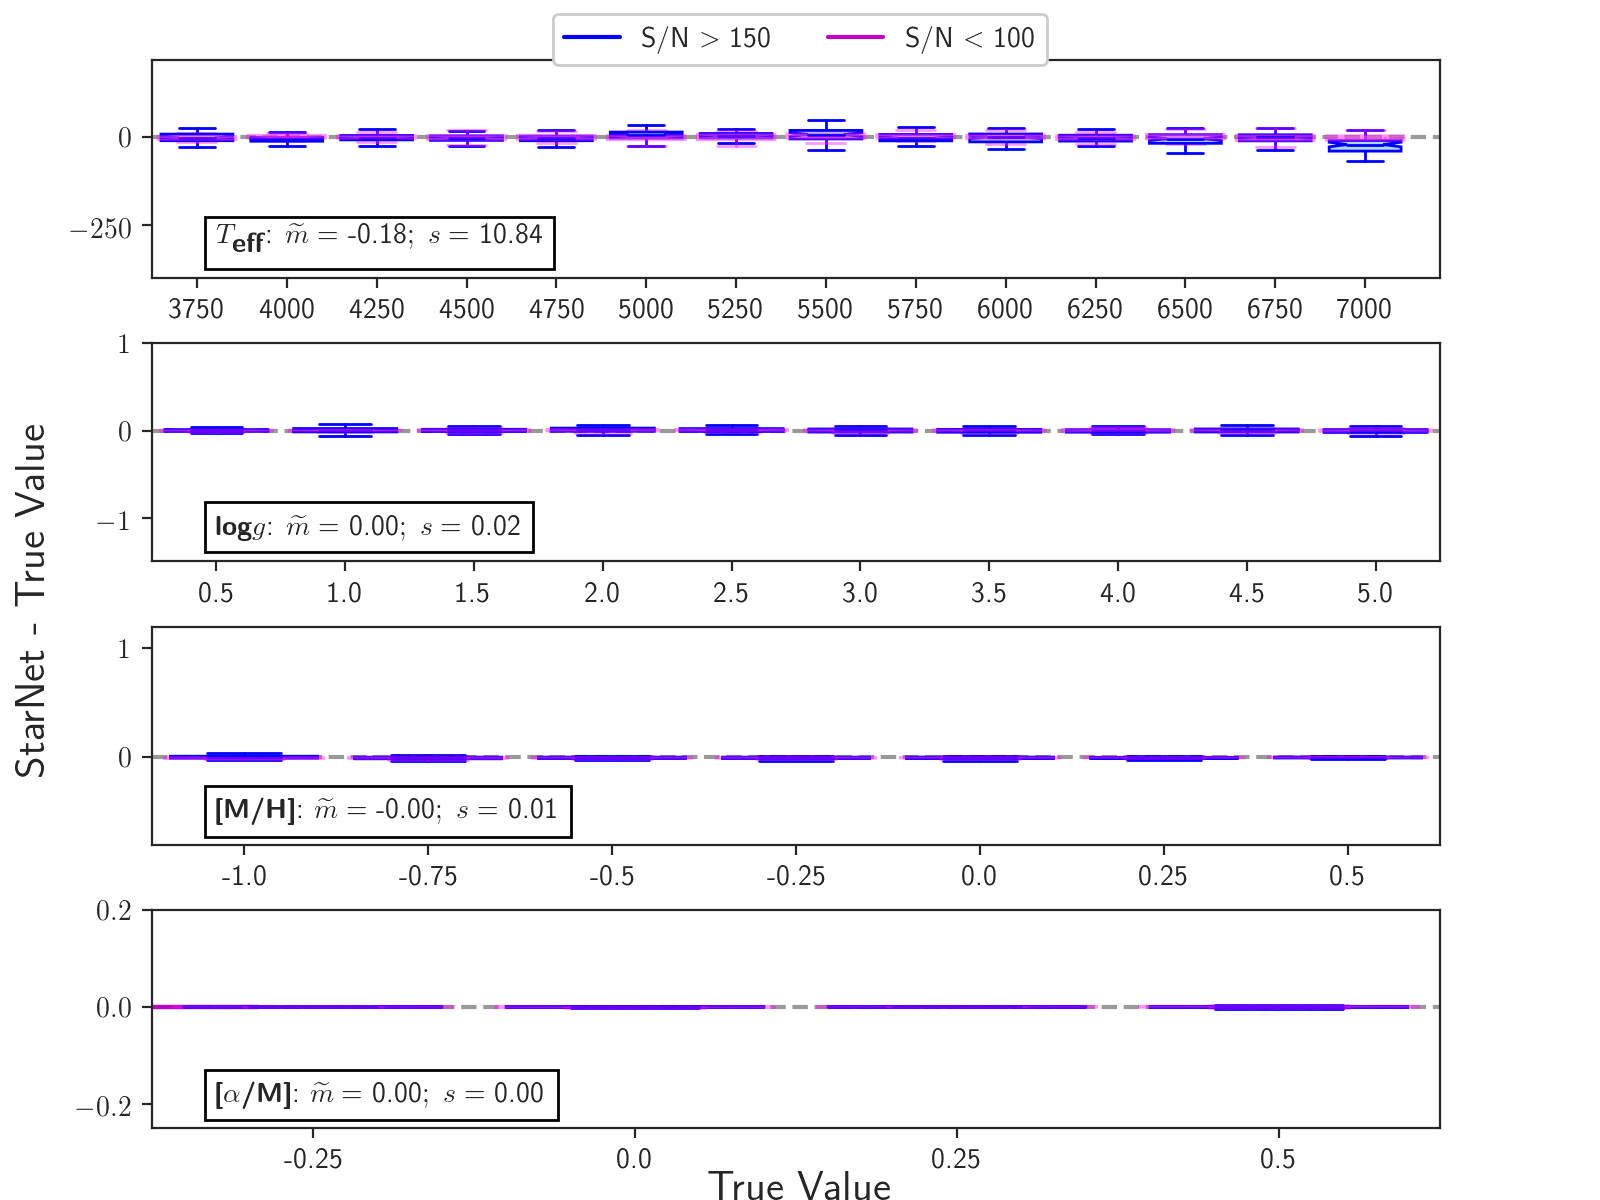

In [130]:
all_targets = test_labels_synth_denorm
all_pred = test_pred_synth
z = np.divide(1, noise_synth)

label_names = [r'$T_{\textbf{eff}}$',
               r'log$g$',r'[M/H]',
               r'[$\alpha$/M]',
               r'$v_{\textbf{rot}}$',
               r'$v_\textbf{{rad}}$',
               r'$v_\textbf{{micro}}$']
centers = [np.arange(3750,7001,250), 
           np.arange(0.5, 5.01, 0.5),
           np.arange(-1.0, 0.51, 0.25),
           np.arange(-0.25, 0.51, 0.25),
           np.arange(0, 80, 10),
           np.arange(-150, 150, 25)]
widths = [100, 0.1, 0.1, 0.1, 5, 12.5]
xlims=[[0,43], [0,30], [0,21], [0,12], [0,25], [0,37]]
ylims=[[-400,220], [-1.5,1], [-0.8,1.2], [-0.25,0.2], [-35,15], [-25,20]]
highsnr=150
lowsnr=100
difference = all_pred-all_targets
x_lab=r'True Value'
y_lab=r'StarNet - True Value'
make_boxplots(all_targets[:,:6], 
              z, 
              difference[:,:6], 
              highsnr, 
              lowsnr, 
              centers, widths, xlims, ylims,
              label_names,
              x_lab,
              y_lab)

### Looking at differences between StarNet trained on INTRIGOSS spectra with and without noise added before continuum normalization

In [17]:
model_path_noise = 'StarNet_2018-10-31_run1/'
model_path_nonoise = 'StarNet_2018-11-23_run1/'
model_trained_noise = load_model(model_path_noise + 'weights.best.h5')
model_trained_nonoise = load_model(model_path_nonoise + 'weights.best.h5')

# Predict on synthetic spectra
test_pred_noise = model_trained_noise.predict(X, batch_size=5, verbose=0)
test_pred_nonoise = model_trained_nonoise.predict(X, batch_size=5, verbose=0)
test_pred_noise = data.denormalize(test_pred_noise)
test_pred_nonoise = data.denormalize(test_pred_nonoise)
test_labels = y_synth

<IPython.core.display.Javascript object>


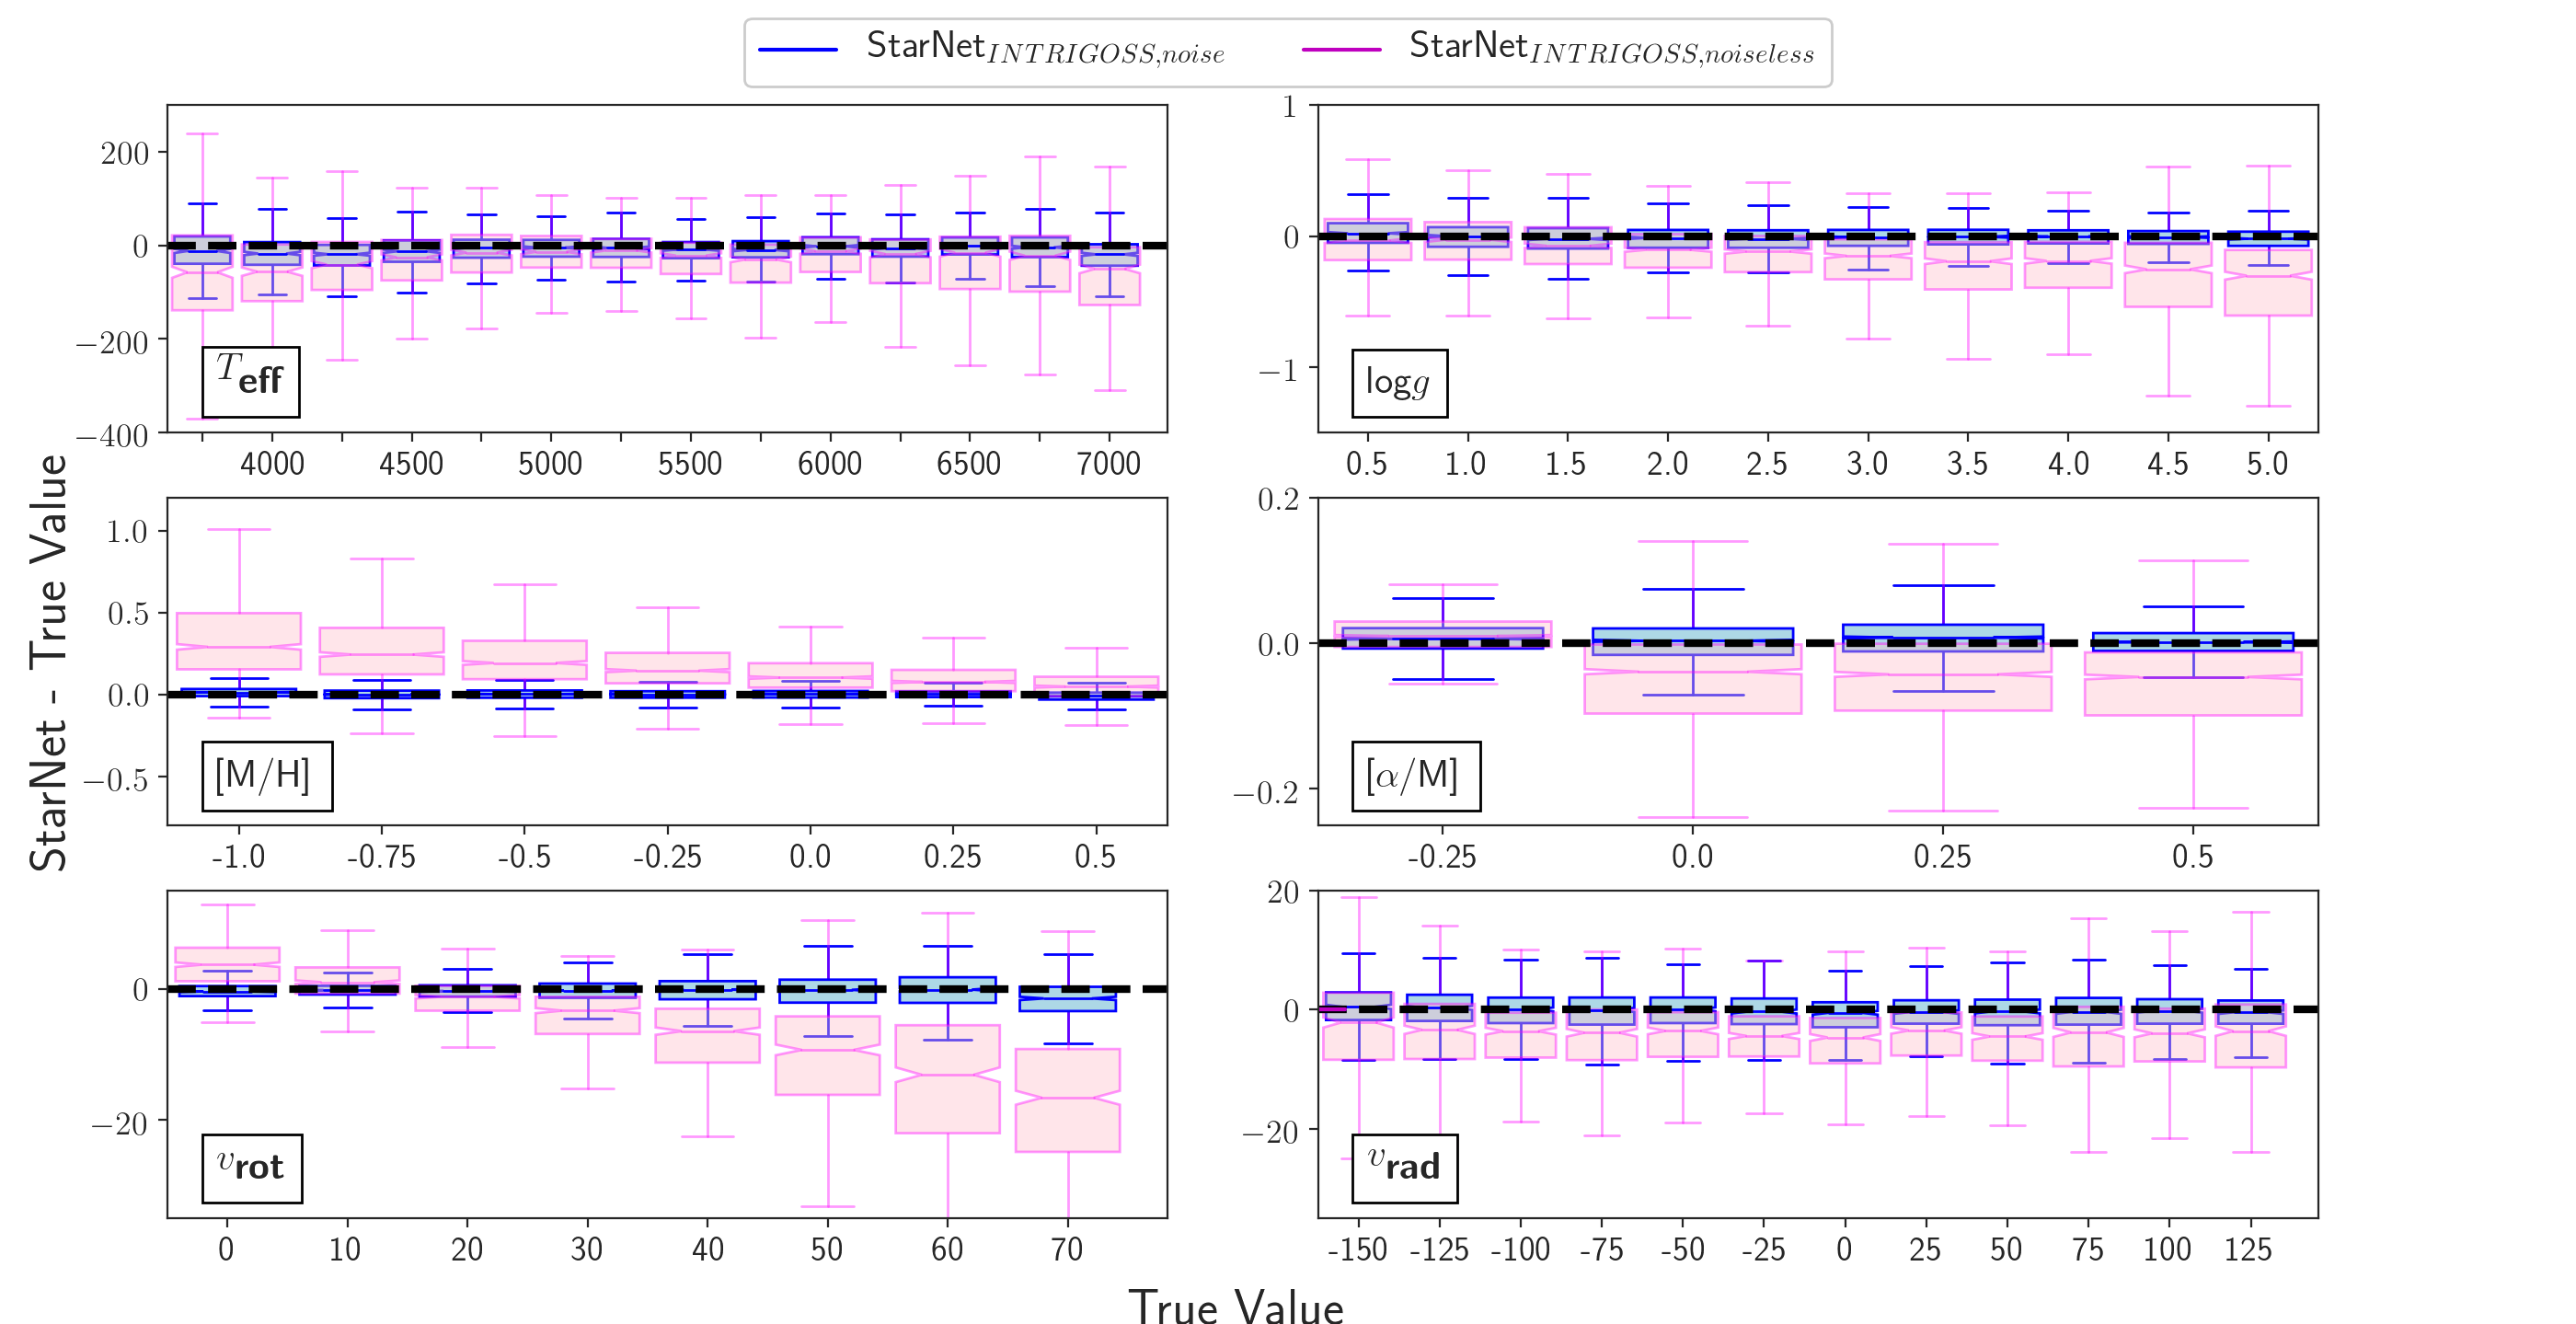

In [157]:
label_names = [r'$T_{\textbf{eff}}$',
               r'log$g$',r'[M/H]',
               r'[$\alpha$/M]',
               r'$v_{\textbf{rot}}$',
               r'$v_\textbf{{rad}}$',
               r'$v_\textbf{{micro}}$']
centers = [np.arange(3750,7001,250), 
           np.arange(0.5, 5.01, 0.5),
           np.arange(-1.0, 0.51, 0.25),
           np.arange(-0.25, 0.51, 0.25),
           np.arange(0, 80, 10),
           np.arange(-150, 150, 25)]
widths = [100, 0.1, 0.1, 0.1, 5, 12.5]
xlims=[[0,43], [0,30], [0,21], [0,12], [0,25], [0,37]]
ylims=[[-400,300], [-1.5,1], [-0.8,1.2], [-0.25,0.2], [-35,15], [-35,20]]
difference_noise = test_pred_noise - test_labels
difference_nonoise = test_pred_nonoise - test_labels
x_lab=r'True Value'
y_lab=r'StarNet - True Value'
legend_text = (r'StarNet$_{INTRIGOSS, noise}$', 
               r'StarNet$_{INTRIGOSS, noiseless}$')

inds = z<100 # Grab data with S/N < 100
xdata = test_labels[inds]
ydata_noise = difference_noise[inds]
ydata_nonoise = difference_nonoise[inds]

make_boxplots_two_datasets(xdata[:,:6],
                           ydata_noise[:,:6], 
                           ydata_nonoise[:,:6],
                           centers, widths, xlims, ylims,
                           label_names,
                           x_lab,
                           y_lab,
                           legend_text)

## Load UVES dataset

In [118]:
#folder = '/home/spiffical/data/spiffical/Data/realspec/UVES/'
folder='/spiffical/spectra/preprocessed/flames-uves/'
#file_name = 'UVES_GE_MW_4835-5395_updated.h5' #'UVES_GE_MW_4835-5395.h5' #'UVES_GE_MW_5840-6800.h5'
file_name = 'UVES_GE_MW_4835-5395_csigma.h5'
#file_name = 'UVES_GE_MW_4835-5395.h5'
with h5py.File(folder+file_name, "r") as f:
        X_uves = f['spectra_statcont'][:]
        y_uves = np.column_stack([f['teff'][:], f['logg'][:], f['fe_h'][:], f['v_rad'][:], f['vmicro'][:]])
        snr_uves = f['SNR'][:]
        ges_type = f['ges_type'][:]
        objects = f['object'][:]
        err_spectra = f['error_spectra'][:]

# Take care of bad values
for spec in X_uves:
    spec[spec>1.03]=0
    spec[spec<0]=0
    
# Mask telluric lines
X_uves = mask_tellurics(os.path.join(starnet_data_folder, 'telluric_lines.txt'), X_uves, wave_grid)

<IPython.core.display.Javascript object>


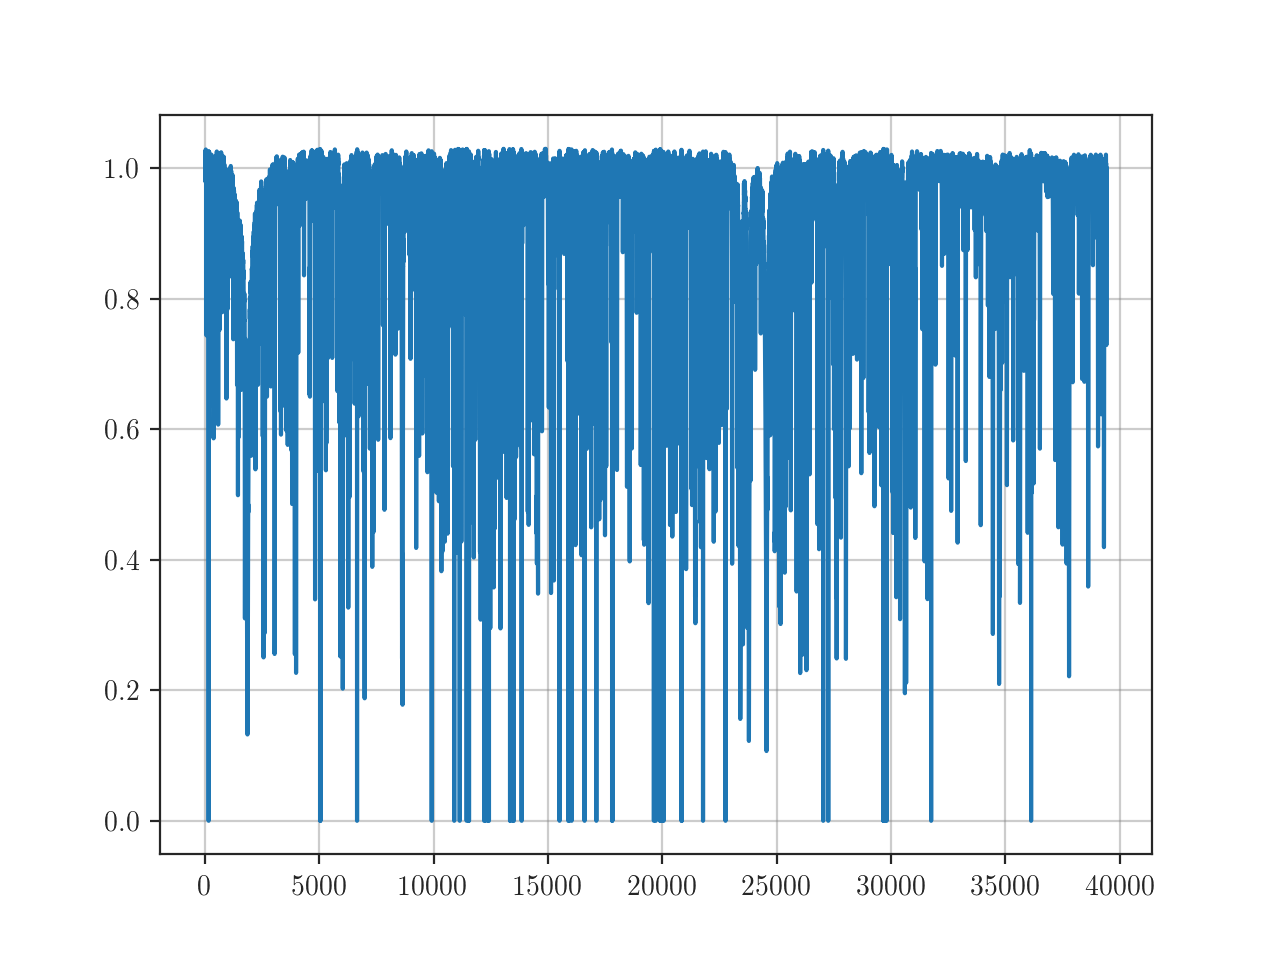

In [123]:
%matplotlib notebook
#plt.plot(err_spectra[10])
plt.plot(X_uves[1000])

## Predict on UVES dataset

In [120]:
# Reshape data for compatibility with neural network
X = np.reshape(X_uves, (np.shape(X_uves)[0], np.shape(X_uves)[1], 1))

# Predict on UVES spectra
test_pred = model.predict(X, batch_size=5, verbose=0)
test_pred_uves = denormalize(test_pred, mu, sigma)

In [10]:
def reject_outliers(data, m = 4.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

In [143]:
np.unique(ges_type)

array(['GE_CL', 'GE_MW', 'GE_MW_BL', 'GE_SD_BC', 'GE_SD_BM', 'GE_SD_BW',
       'GE_SD_CR', 'GE_SD_GC', 'GE_SD_MC', 'GE_SD_OC', 'GE_SD_PC',
       'GE_SD_RV', 'GE_SD_TL'], dtype='|S8')

<IPython.core.display.Javascript object>


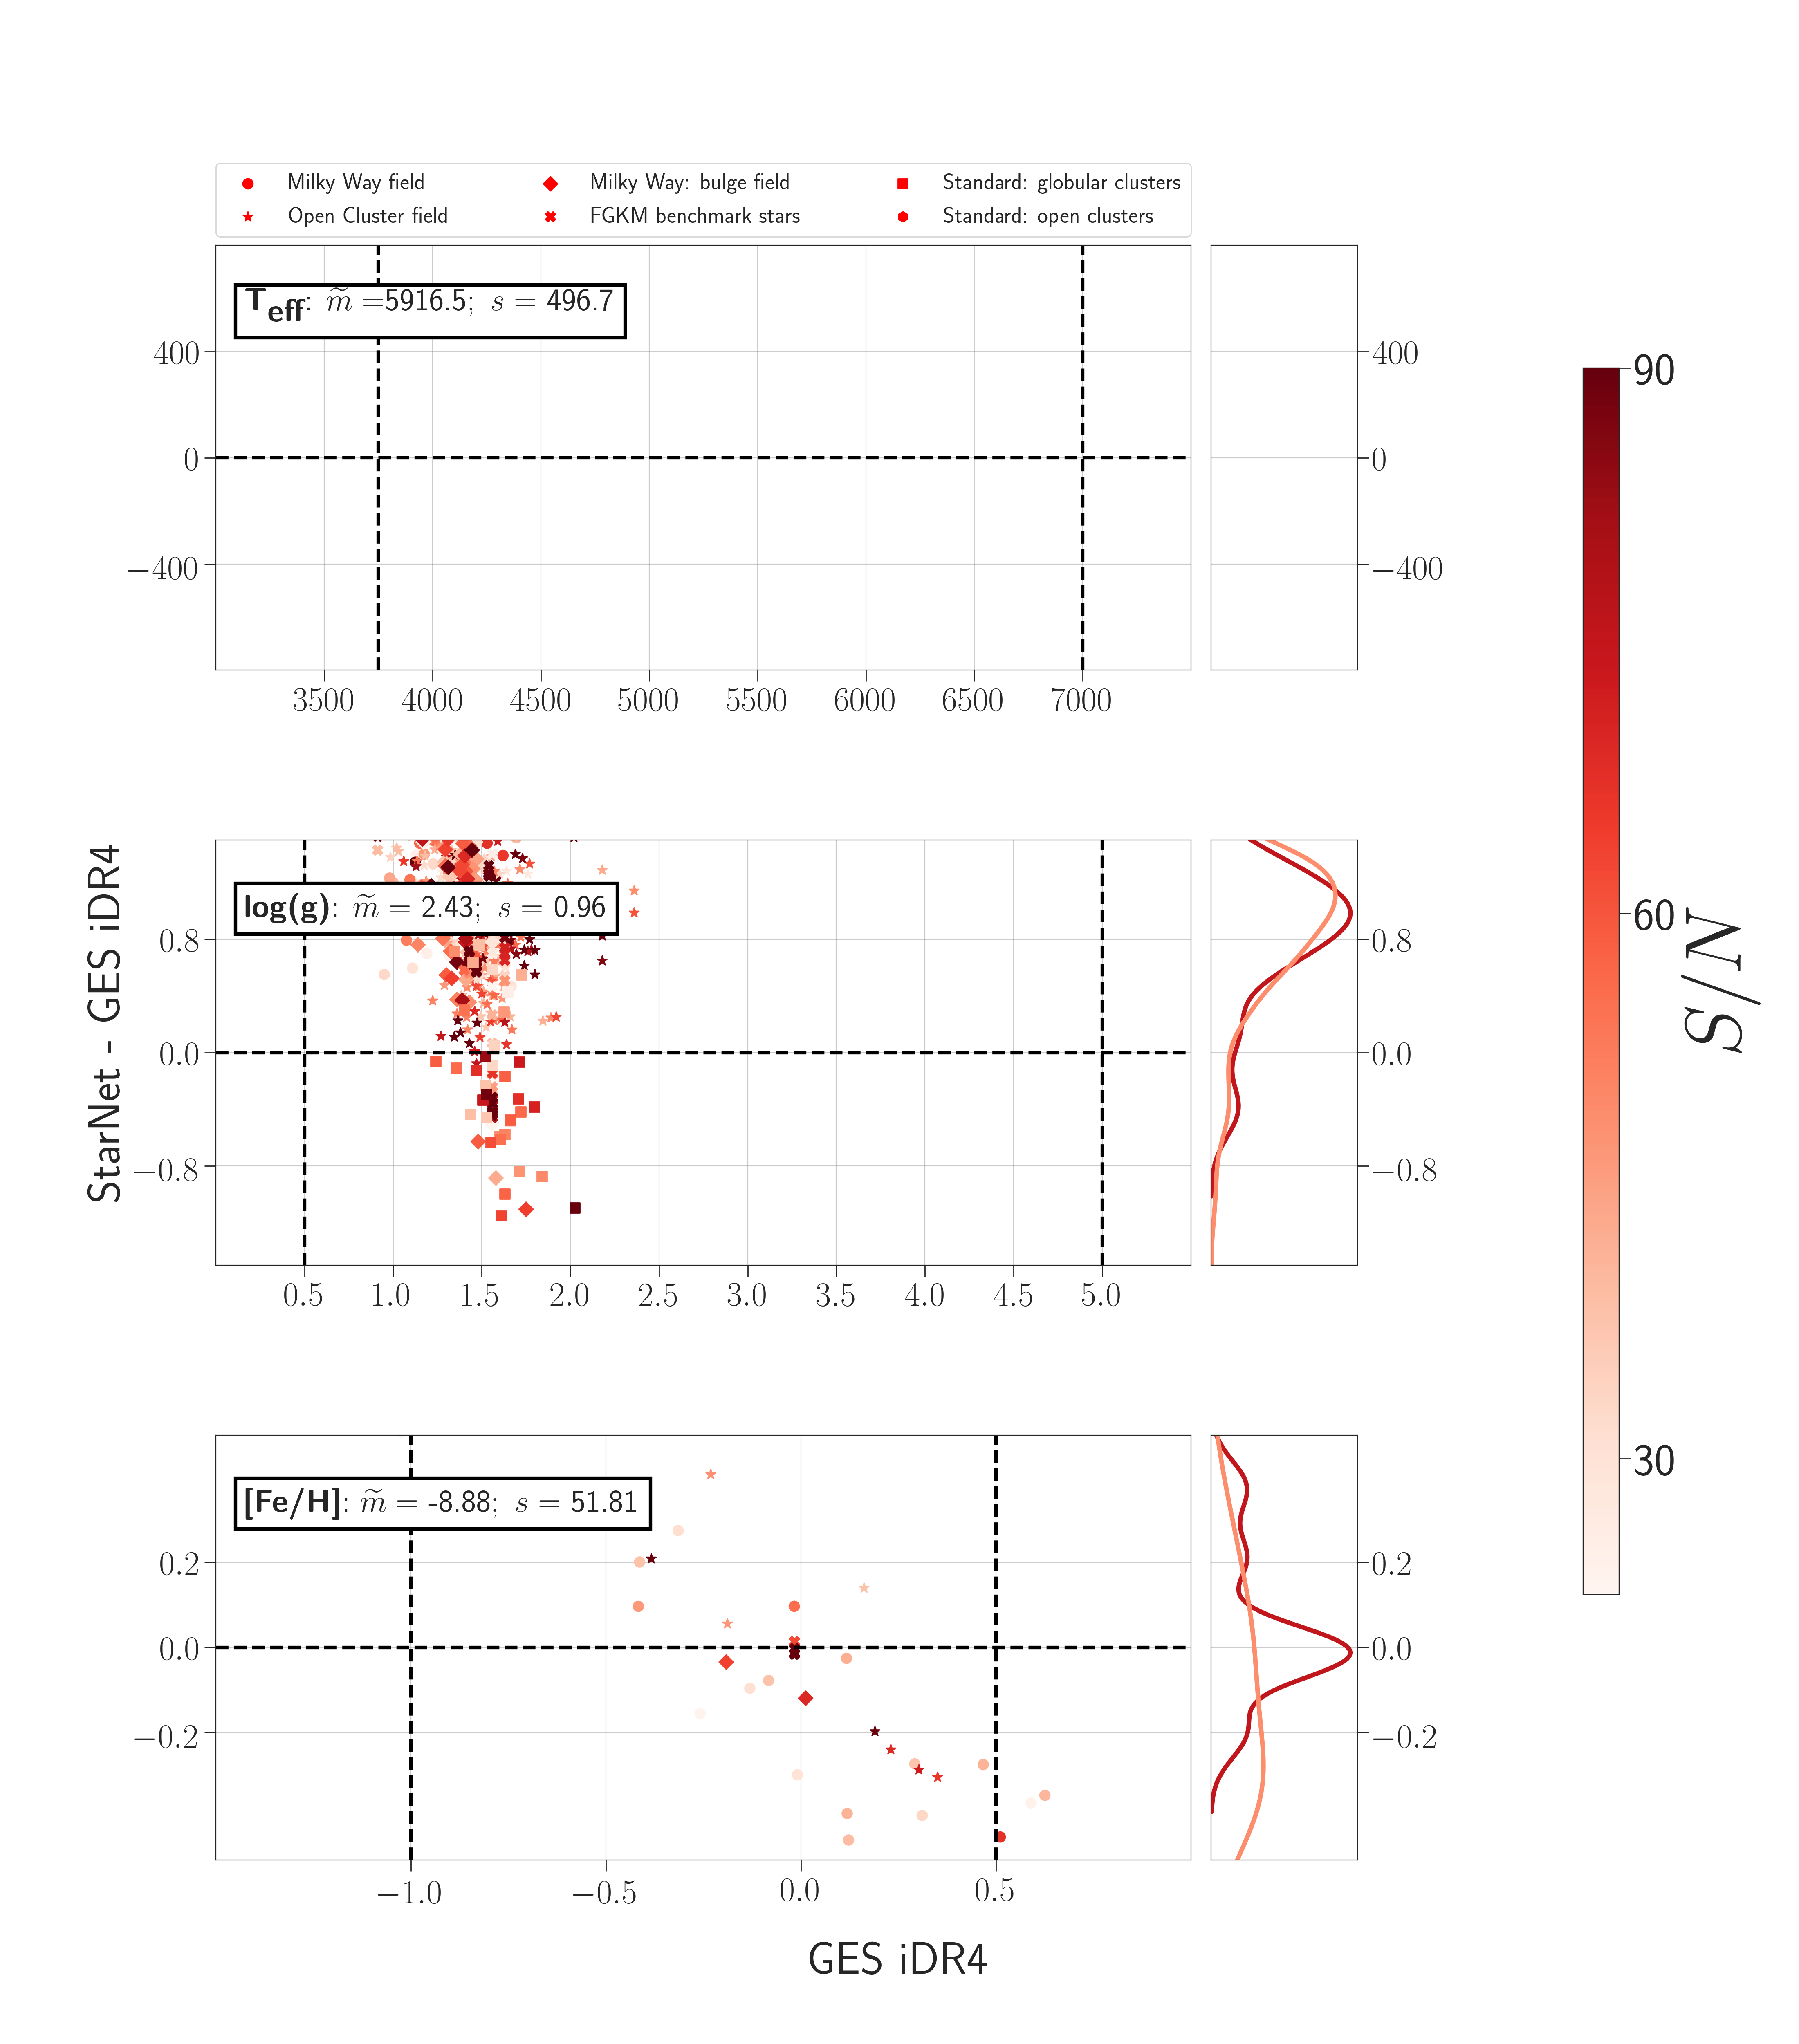

In [121]:
all_targets = y_uves[:,[0,1,2]]
all_pred = test_pred_uves[:,[0,1,2]]#,5,6]]
z = snr_uves

# Deal with outlier radial velocity predictions (but look more into this later...)
#d_ = all_targets[:,3] - all_pred[:,3]
#d = np.abs(d_ - np.nanmedian(d_))
#mdev = np.nanmedian(d)
#s = d/mdev if mdev else 0.
#good_indices = s<12
#all_targets_mod = all_targets[good_indices]
#all_pred_mod = all_pred[good_indices]
#z_mod = snr_uves[good_indices]
#ges_type_mod = ges_type[good_indices]
#objects_mod = objects[good_indices]
#uves_spectra_mod = X_uves[good_indices]
groups_wanted = ['GE_MW', 'GE_CL', 'GE_MW_BL', 'GE_SD_BM', 'GE_SD_GC', 'GE_SD_OC']
#groups_wanted = ['GE_MW', 'GE_CL', 'GE_MW_BL', 'GE_SD_GC', 'GE_SD_OC']
#groups_wanted = ['GE_SD_CR']
#groups_wanted = ['GE_MW']
#ges_type_mod = None
#groups_wanted = None

snr_max=120
x_lab=r'GES iDR4'
y_lab=r'StarNet - GES iDR4'
label_names = [r'T$_{\textbf{eff}}$',r'log(g)',r'[Fe/H]',r'v$_\textbf{{rad}}$',r'v$_\textbf{{micro}}$']
cmap = 'Reds'
plot_lims = [[3000., 7500.], [0.0, 5.5], [-1.5, 1.0], [-250, 250], [0.5, 2.2]]
x_tick_stepsizes = [500, 0.5, 0.5, 50, 0.5]
grid_lims = [[3750., 7000.], [0.5, 5], [-1.0, 0.5], [-200, 200], [1., 2.]]
resid_lims = [[-800., 800.], [-1.5, 1.5], [-0.5, 0.5], [-30, 30], [-1, 1]]

plot_compare_estimates_resid(x_data=all_targets, 
                             y_data=all_pred, 
                             snr=z, 
                             savename=None, 
                             x_lab=x_lab, 
                             y_lab=y_lab, 
                             snr_max=snr_max, 
                             cmap=cmap,
                             label_names=label_names,
                             lims=plot_lims,
                             grid_lims=grid_lims,
                             resid_lims=resid_lims,
                             x_tick_steps=x_tick_stepsizes,
                             indx=3,
                             categories=ges_type,
                             groups_wanted=groups_wanted)
#plt.savefig('demo.png', transparent=True)

# Now to predict on the Gaia Benchmark Stars

- All spectra for the benchmark stars were downloaded from ftp://obsftp.unige.ch/pub/sblancoc/Gaia_Benchmark_Stars_Library/
- Temperatures and surface gravities from http://cdsads.u-strasbg.fr/abs/2015A&A...582A..49H
- Metallicities from http://cdsads.u-strasbg.fr/abs/2014A&A...564A.133J



In [33]:
benchmarks_folder = os.path.join(starnet_data_folder, 'benchmark-stars/')
ref_file = os.path.join(benchmarks_folder, 'benchmark_stars_overview.txt')
ref = np.genfromtxt(ref_file, dtype=str, delimiter='\t')

In [34]:
df_full = pd.DataFrame(data=ref[1:,1:],    # values
             index=ref[1:,0],    # 1st column as index
             columns=ref[0,1:])  # 1st row as the column names

# Grab only spectra taken with UVES
df_uves_all = df_full[df_full['origin']=='BS_UVES']

# Some entries appear twice, so separate these
list_2 = [ID for ID in df_uves_all.ID if '-2' in ID] # All entries with a '-2' in the ID name
df_uves1 = df_uves_all[~df_uves_all['ID'].isin(list_2)]
df_uves2 = df_uves_all[df_uves_all['ID'].isin(list_2)]

# Convert everything from strings to numbers
df_uves1['Teff'] = df_uves1['Teff'].astype(int)
df_uves1['logg'] = df_uves1['logg'].astype(float)
df_uves1['[Fe/H]'] = df_uves1['[Fe/H]'].astype(float)
df_uves2['Teff'] = df_uves2['Teff'].astype(int)
df_uves2['logg'] = df_uves2['logg'].astype(float)
df_uves2['[Fe/H]'] = df_uves2['[Fe/H]'].astype(float)

/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

In [35]:
df_uves1

ID   origin    snr         R     HIP_ID          Group  \
Arcturus  UVES_Arcturus-1  BS_UVES  283.0   95000.0   HIP69673     FGK giants   
HD102200    UVES_HD102200  BS_UVES  160.0   51690.0   HIP57360     Metal-poor   
HD106038    UVES_HD106038  BS_UVES  254.0   47254.0   HIP59490     Metal-poor   
HD122563  UVES_HD122563-1  BS_UVES  318.0   72000.0   HIP68594     FGK giants   
HD140283  UVES_HD140283-1  BS_UVES  293.0   78000.0   HIP76976  FGK subgiants   
HD201891    UVES_HD201891  BS_UVES  107.0   66320.0  HIP104659     Metal-poor   
HD298986    UVES_HD298986  BS_UVES  173.0   51690.0   HIP50382     Metal-poor   
HD84937    UVES_HD84937-1  BS_UVES  224.0   72000.0   HIP48152       F dwarfs   
Procyon    UVES_Procyon-1  BS_UVES  360.0   75000.0   HIP37279       F dwarfs   
Sun            UVES_Sun-1  BS_UVES  383.0   78000.0        NaN       G dwarfs   
alfCenA    UVES_alfCenA-1  BS_UVES  316.0   85000.0   HIP86796       G dwarfs   
alfCet      UVES_alfCet-1  BS_UVES  207.0   90000.0   HIP14135       M giants   
alfTau        UVES_alfTau  BS_UVES  147.0  107200.0   HIP21421       M giants   
betGem        UVES_betGem  BS_UVES  163.0  107200.0   HIP37826     FGK giants   
betHyi      UVES_betHyi-1  BS_UVES  419.0   78000.0    HIP2021  FGK subgiants   
delEri      UVES_delEri-1  BS_UVES  206.0   75000.0   HIP17378  FGK subgiants   
epsEri      UVES_epsEri-1  BS_UVES  220.0   90000.0   HIP16537       K dwarfs   
muAra        UVES_muAra-1  BS_UVES  309.0   95000.0   HIP71683       G dwarfs   
psiPhe        UVES_psiPhe  BS_UVES  118.0   74450.0    HIP8837       M giants   

          Teff eTeff   logg   elogg  ... [Ni/H] e[Ni/H] [Sc/H] e[Sc/H]  \
Arcturus  4286    35  1.640    0.09  ...  -0.49     0.1  -0.43    0.15   
HD102200  6155    80  4.220    0.07  ...    NaN     NaN    NaN     NaN   
HD106038  6121    80  4.550    0.14  ...    NaN     NaN    NaN     NaN   
HD122563  4587    60  1.610    0.07  ...  -2.69    0.13   -2.5    0.11   
HD140283  5522   105  3.580    0.11  ...  -2.61    0.11  -2.67    0.07   
HD201891  5948    80  4.300    0.04  ...    NaN     NaN    NaN     NaN   
HD298986  6223   100  4.190    0.19  ...    NaN     NaN    NaN     NaN   
HD84937   6356    97  4.060    0.04  ...  -2.06    0.15   -1.9    0.16   
Procyon   6554    84  4.000    0.02  ...  -0.11    0.09  -0.13    0.07   
Sun       5771     1  4.438  0.0002  ...    0.0    0.11    0.0    0.15   
alfCenA   5792    16  4.310    0.01  ...   0.25    0.05    0.3    0.06   
alfCet    3796    65  0.680    0.23  ...  -0.64    0.28   -0.4    0.31   
alfTau    3927    40  1.110    0.19  ...   -0.4    0.29  -0.26    0.29   
betGem    4858    60  2.900    0.08  ...   0.09    0.09   0.06    0.14   
betHyi    5873    45  3.980    0.02  ...  -0.09    0.05  -0.04    0.05   
delEri    4954    30  3.760    0.02  ...   0.09    0.09   0.08    0.12   
epsEri    5076    30  4.610    0.03  ...  -0.18    0.08  -0.16     0.1   
muAra     5902    66  4.300    0.03  ...   0.42    0.07    0.4    0.08   
psiPhe    3472    92  0.510    0.18  ...  -1.22    0.63  -0.67    0.53   

          [Si/H] e[Si/H] [Ti/H] e[Ti/H]  [V/H] e[V/H]  
Arcturus   -0.25    0.07  -0.31    0.11  -0.44   0.14  
HD102200     NaN     NaN    NaN     NaN    NaN    NaN  
HD106038     NaN     NaN    NaN     NaN    NaN    NaN  
HD122563   -2.33    0.09   -2.5    0.15   -2.7   0.13  
HD140283   -2.25    0.06  -2.42    0.12    NaN    NaN  
HD201891     NaN     NaN    NaN     NaN    NaN    NaN  
HD298986     NaN     NaN    NaN     NaN    NaN    NaN  
HD84937    -1.73    0.18  -1.66    0.12    NaN    NaN  
Procyon    -0.03    0.08  -0.07     0.1  -0.14    0.1  
Sun          0.0    0.08    0.0    0.08    0.0   0.05  
alfCenA     0.25    0.03   0.21    0.05   0.24   0.07  
alfCet     -0.52     0.2  -0.53    0.19  -0.17   0.37  
alfTau     -0.18    0.21  -0.34    0.23   -0.2   0.35  
betGem      0.14    0.08   0.06    0.11   0.06   0.19  
betHyi     -0.07    0.04  -0.07    0.06  -0.08   0.06  
delEri      0.14    0.07 

In [36]:
# Define parameters needed for continuum normalization
wave_grid_uves = wave_grid
line_regions = [[4210, 4240], [4250, 4410], [4333, 4388], [4845, 4886], [5160, 5200], [5874, 5916], [6530, 6590]]
segments_step = 10. # divide the spectrum into segments of 10 Angstroms
segments = range(0, len(wave_grid_uves), int(segments_step/(wave_grid_uves[1]-wave_grid_uves[0])))

## Finding best model, predicting on benchmarks (skip this cell if you know which model you want to use)

In [131]:
import warnings
warnings.filterwarnings("ignore")

benchmarks_folder = '/home/spiffical/data/spiffical/gaia-ESO/benchmark-stars/'
model_names = ['StarNet_2018-11-05_run1/', 'StarNet_2018-10-31_run1/', 'StarNet_2018-07-27_run1/', 
               'StarNet_2018-10-05_run1/', 'StarNet_2018-10-30_run1/', 'StarNet_2018-07-13_run1/', 
               'StarNet_2018-07-21_run1/']
for model_name in model_names:
    try:
        model_path = model_name+'weights.best.h5'
        model_ = load_model(model_path)
    except:
        model_path = model_name+'model_weights.h5'
        model_ = load_model(model_path)
    bms_temp = dict()
    bms_temp.update(benchmark_stars)
    for star in bms_temp:
        bms = bms_temp[star]
        if bms['filename'] is None:
            bms['starnet_teff'] = np.nan
            bms['starnet_logg'] = np.nan
            bms['starnet_feh'] = np.nan
            bms['starnet_alpha'] = np.nan
        else:

            # Load .txt file containing wavelength and flux arrays
            x = np.loadtxt(benchmarks_folder + '%s.txt' % bms['filename'], skiprows=1)
            wave, flux = x[:,0], x[:,1]
            wave*=10.  # Convert to angstroms

            # Rebin to UVES grid
            f_ = np.ones(len(wave))
            spec_ = spectrum.ArraySourceSpectrum(wave=wave, flux=flux)
            filt = spectrum.ArraySpectralElement(wave, f_, waveunits='angstrom')
            obs = observation.Observation(spec_, filt, binset=wave_grid_uves, force='taper')
            flux = obs.binflux

            # Continuum normalize the spectrum
            flux, _, _ = continuum_normalize(flux, line_regions, segments, wave_grid_uves, 
                                          multiprocess=False)

            # Mask telluric lines
            flux = mask_tellurics('telluric_lines.txt', flux, wave_grid)
            flux[flux>1.03]=0
            flux[flux<0]=0

            # Reshape data for compatibility with neural network
            X = np.reshape(flux, (np.shape(np.atleast_2d(flux))[0], np.shape(np.atleast_2d(flux))[1], 1))

            # Predict on synthetic spectra
            try:
                test_pred = model_.predict(X, batch_size=1, verbose=0)
            except:
                print 'Problem with model %s' % model_name
                break
            test_pred = data.denormalize(test_pred)

            # Add [Fe/H] flag if benchmark value is outside range of INTRIGOSS grid
            if bms['fe_h'] < -1.0 or bms['fe_h'] > 0.5:
                bms['fe_h_flag'] = 1

            # Add StarNet predictions to dictionary
            bms['starnet_teff'] = int(test_pred[0][0])
            bms['delta_teff'] = int(test_pred[0][0]) - bms['teff']
            bms['starnet_logg'] = test_pred[0][1]
            bms['delta_logg'] = test_pred[0][1] - bms['logg']
            bms['starnet_feh'] = test_pred[0][2]
            bms['delta_feh'] = test_pred[0][2] - bms['fe_h']
            bms['starnet_alpha'] = test_pred[0][3]
    
    column_order = ['teff','starnet_teff','delta_teff', 
                    'logg','starnet_logg','delta_logg',
                    'fe_h','starnet_feh', 'delta_feh',
                    'starnet_alpha','teff_flag','logg_flag',
                    'fe_h_flag', 'filename']
    df = pd.DataFrame.from_dict(bms_temp, orient='index')[column_order]
    
    # Separate the MRDs from the MRGs
    metal_rich = df['fe_h']>-1.
    dwarf = df['logg'] > 3.5
    giant = df['logg'] <= 3.5
    filename_exists = ~df['filename'].isnull()
    good_value = df['delta_teff']>-1000
    MRD = df[metal_rich & dwarf & filename_exists & good_value]
    MRG = df[metal_rich & giant & filename_exists & good_value]
    # Drop Alpha Tau because it has a bad spectrum!
    try:
        MRG = MRG.drop('alpha Tau')
    except:
        print 'alpha Tau already gone'
    MRD_and_MRG = MRD.append(MRG)

    average_quadratic_diff_teff_MRD = np.nanmean(np.abs(MRD['delta_teff']))
    average_quadratic_diff_logg_MRD = np.nanmean(np.abs(MRD['delta_logg']))
    average_quadratic_diff_feh_MRD = np.nanmean(np.abs(MRD['delta_feh']))
    average_quadratic_diff_teff_MRG = np.nanmean(np.abs(MRG['delta_teff']))
    average_quadratic_diff_logg_MRG = np.nanmean(np.abs(MRG['delta_logg']))
    average_quadratic_diff_feh_MRG = np.nanmean(np.abs(MRG['delta_feh']))

    print model_name
    print 'MRD d_teff: %.2f  d_logg: %.2f  d_feh: %.2f' % (average_quadratic_diff_teff_MRD,
                                                     average_quadratic_diff_logg_MRD,
                                                     average_quadratic_diff_feh_MRD)
    print 'MRG d_teff: %.2f  d_logg: %.2f  d_feh: %.2f' % (average_quadratic_diff_teff_MRG,
                                                     average_quadratic_diff_logg_MRG,
                                                     average_quadratic_diff_feh_MRG)
    
    print ''

StarNet_2018-11-05_run1/
MRD d_teff: 121.71  d_logg: 0.33  d_feh: 0.07
MRG d_teff: 139.00  d_logg: 0.49  d_feh: 0.22

alpha Tau already gone
StarNet_2018-07-27_run1/
MRD d_teff: 96.71  d_logg: 0.14  d_feh: 0.05
MRG d_teff: 110.00  d_logg: 0.61  d_feh: 0.16

StarNet_2018-10-31_run1/
MRD d_teff: 94.57  d_logg: 0.26  d_feh: 0.05
MRG d_teff: 66.67  d_logg: 0.44  d_feh: 0.16

alpha Tau already gone
StarNet_2018-07-27_run1/
MRD d_teff: 96.71  d_logg: 0.14  d_feh: 0.05
MRG d_teff: 110.00  d_logg: 0.61  d_feh: 0.16

StarNet_2018-10-05_run1/
MRD d_teff: 97.29  d_logg: 0.18  d_feh: 0.07
MRG d_teff: 215.00  d_logg: 0.49  d_feh: 0.19

alpha Tau already gone
StarNet_2018-10-30_run1/
MRD d_teff: 156.86  d_logg: 0.42  d_feh: 0.11
MRG d_teff: 75.33  d_logg: 0.61  d_feh: 0.22

Problem with model StarNet_2018-07-13_run1/
alpha Tau already gone
StarNet_2018-07-13_run1/
MRD d_teff: 156.86  d_logg: 0.42  d_feh: 0.11
MRG d_teff: 75.33  d_logg: 0.61  d_feh: 0.22

Problem with model StarNet_2018-07-21_run1/
a

## Get final predictions on benchmarks for chosen model

In [42]:
df_uves1 = df_uves1.drop('alfTau')

In [93]:
import warnings
warnings.filterwarnings("ignore")
telluric_filename = 'telluric_lines.txt'
telluric_file = os.path.join(starnet_data_folder, telluric_filename)
fluxes_norm = []
fluxes_nonorm = []
continuums = []
starnet_teff = []
starnet_logg = []
starnet_feh = []
starnet_alpha = []
df_uves = df_uves1
for index, star in df_uves.iterrows():
    print star['ID']
    # Load .txt file containing wavelength and flux arrays
    x = np.loadtxt(benchmarks_folder + '%s_47000.txt' % star['ID'], skiprows=1)
    wave, flux = x[:,0], x[:,1]
    wave*=10.  # Convert to angstroms

    # Rebin to UVES grid
    f_ = np.ones(len(wave))
    spec_ = spectrum.ArraySourceSpectrum(wave=wave, flux=flux)
    filt = spectrum.ArraySpectralElement(wave, f_, waveunits='angstrom')
    obs = observation.Observation(spec_, filt, binset=wave_grid_uves, force='taper')
    flux = obs.binflux

    fluxes_nonorm.append(flux)
    # Continuum normalize the spectrum
    flux, _, cont = continuum_normalize(flux, line_regions, wave_grid_uves, 10)
    
    continuums.append(cont)
    fluxes_norm.append(flux)

    # Mask telluric lines
    flux = mask_tellurics(telluric_file, flux, wave_grid)
    flux[flux>1.03]=0
    flux[flux<0]=0

    # Reshape data for compatibility with neural network
    X = np.reshape(flux, (np.shape(np.atleast_2d(flux))[0], np.shape(np.atleast_2d(flux))[1], 1))

    # Predict on spectra
    test_pred = model.predict(X, batch_size=1, verbose=0)
    test_pred = denormalize(test_pred, mu, sigma)
    
    starnet_teff.append(int(test_pred[0][0]))
    starnet_logg.append(test_pred[0][1])
    starnet_feh.append(test_pred[0][2])
    starnet_alpha.append(test_pred[0][3])
    
df_uves['StarNet Teff'] = starnet_teff
df_uves['StarNet logg'] = starnet_logg
df_uves['StarNet [Fe/H]'] = starnet_feh
df_uves['StarNet [alpha/M]'] = starnet_alpha

UVES_Arcturus-1
UVES_HD102200
UVES_HD106038
UVES_HD122563-1
UVES_HD140283-1
UVES_HD201891
UVES_HD298986
UVES_HD84937-1
UVES_Procyon-1
UVES_Sun-1
UVES_alfCenA-1
UVES_alfCet-1
UVES_betGem
UVES_betHyi-1
UVES_delEri-1
UVES_epsEri-1
UVES_muAra-1
UVES_psiPhe


### In order to calculate statistics of the predictions, I follow the method outlined in R. Smiljanic et al. (2014, https://arxiv.org/pdf/1409.0568.pdf):

1. Split the stars into three groups, covering separate parts of parameter space:
    - **metal-rich dwarfs (MRD)**: [Fe/H] $\gt$ -1.00 and log*g* $\gt$ 3.5
    - **metal-rich giants (MRG)**: [Fe/H] $\gt$ -1.00 and log*g* $\leq$ 3.5
    - **metal-poor stars**: [Fe/H] $\leq$ -1.00 **NOTE:** INTRIGOSS doesn't go below -1.00 in [Fe/H], so these are not included in the analysis
    
2. Calculate the average quadratic difference between the reference and the derived atmospheric parameters of the stars. If this average quadratic difference is within ± 100 K and ± 0.20 dex of the reference values, the results are considered to be very accurate.


In [94]:
# Separate the MRDs from the MRGs from MPs
metal_rich = df_uves['[Fe/H]'] > -1.
metal_poor = df_uves['[Fe/H]'] <= -1.
dwarf = df_uves['logg'] > 3.5
giant = df_uves['logg'] <= 3.5
MRD = df_uves[metal_rich & dwarf]# & good_value]
MRG = df_uves[metal_rich & giant]# & good_value]
MP = df_uves[metal_poor]
#MRD_and_MRG = MRD.append(MRG)

# Drop Alpha Tau and Psi Phe because they have bad spectra!
try:
    MRG = MRG.drop('alfTau')
except:
    print 'alfTau already gone'
try:
    MP = MP.drop('psiPhe')
except:
    print 'psiPhe already gone'
# Drop very metal poor stars ([Fe/H] < -2)
MP = MP[MP['[Fe/H]'] > -2]

alfTau already gone


In [95]:
MRD[['[Fe/H]', 'StarNet [Fe/H]', 'Teff', 'StarNet Teff', 'logg', 'StarNet logg', 'snr']]

[Fe/H]  StarNet [Fe/H]  Teff  StarNet Teff   logg  StarNet logg  \
Procyon   -0.04       -0.054289  6554          6508  4.000      3.781183   
Sun        0.02        0.004233  5771          5760  4.438      4.394738   
alfCenA    0.24        0.183940  5792          5714  4.310      4.205331   
betHyi    -0.07       -0.099265  5873          5855  3.980      3.927824   
delEri     0.06        0.098096  4954          5083  3.760      3.888537   
epsEri    -0.10       -0.104445  5076          5103  4.610      4.683217   
muAra      0.33        0.277813  5902          5719  4.300      4.217593   

           snr  
Procyon  360.0  
Sun      383.0  
alfCenA  316.0  
betHyi   419.0  
delEri   206.0  
epsEri   220.0  
muAra    309.0

In [96]:
MRG[['[Fe/H]', 'StarNet [Fe/H]', 'Teff', 'StarNet Teff', 'logg', 'StarNet logg']]

[Fe/H]  StarNet [Fe/H]  Teff  StarNet Teff  logg  StarNet logg
Arcturus   -0.53       -0.547917  4286          4447  1.64      1.786533
alfCet     -0.45       -0.450306  3796          3789  0.68      0.863609
betGem      0.12        0.085443  4858          4970  2.90      3.041674

In [97]:
MP[['[Fe/H]', 'StarNet [Fe/H]', 'Teff', 'StarNet Teff', 'logg', 'StarNet logg']]

[Fe/H]  StarNet [Fe/H]  Teff  StarNet Teff  logg  StarNet logg
HD102200   -1.16       -1.043154  6155          6188  4.22      4.216928
HD106038   -1.27       -1.058721  6121          6132  4.55      4.221545
HD201891   -1.00       -0.998135  5948          5982  4.30      4.335018
HD298986   -1.31       -1.087705  6223          6302  4.19      4.222500

In [25]:
# Load .txt file containing wavelength and flux arrays
#x = np.loadtxt(benchmarks_folder + 'UVES_alfTau_47000.txt', skiprows=1)
#x = np.loadtxt(benchmarks_folder + 'UVES_alfCet-1_47000.txt', skiprows=1)
x = np.loadtxt(benchmarks_folder + 'UVES_psiPhe_47000.txt', skiprows=1)
wave, flux = x[:,0], x[:,1]
wave*=10.  # Convert to angstroms

# Rebin to UVES grid
f_ = np.ones(len(wave))
spec_ = spectrum.ArraySourceSpectrum(wave=wave, flux=flux)
filt = spectrum.ArraySpectralElement(wave, f_, waveunits='angstrom')
obs = observation.Observation(spec_, filt, binset=wave_grid_uves, force='taper')
flux = obs.binflux

<IPython.core.display.Javascript object>


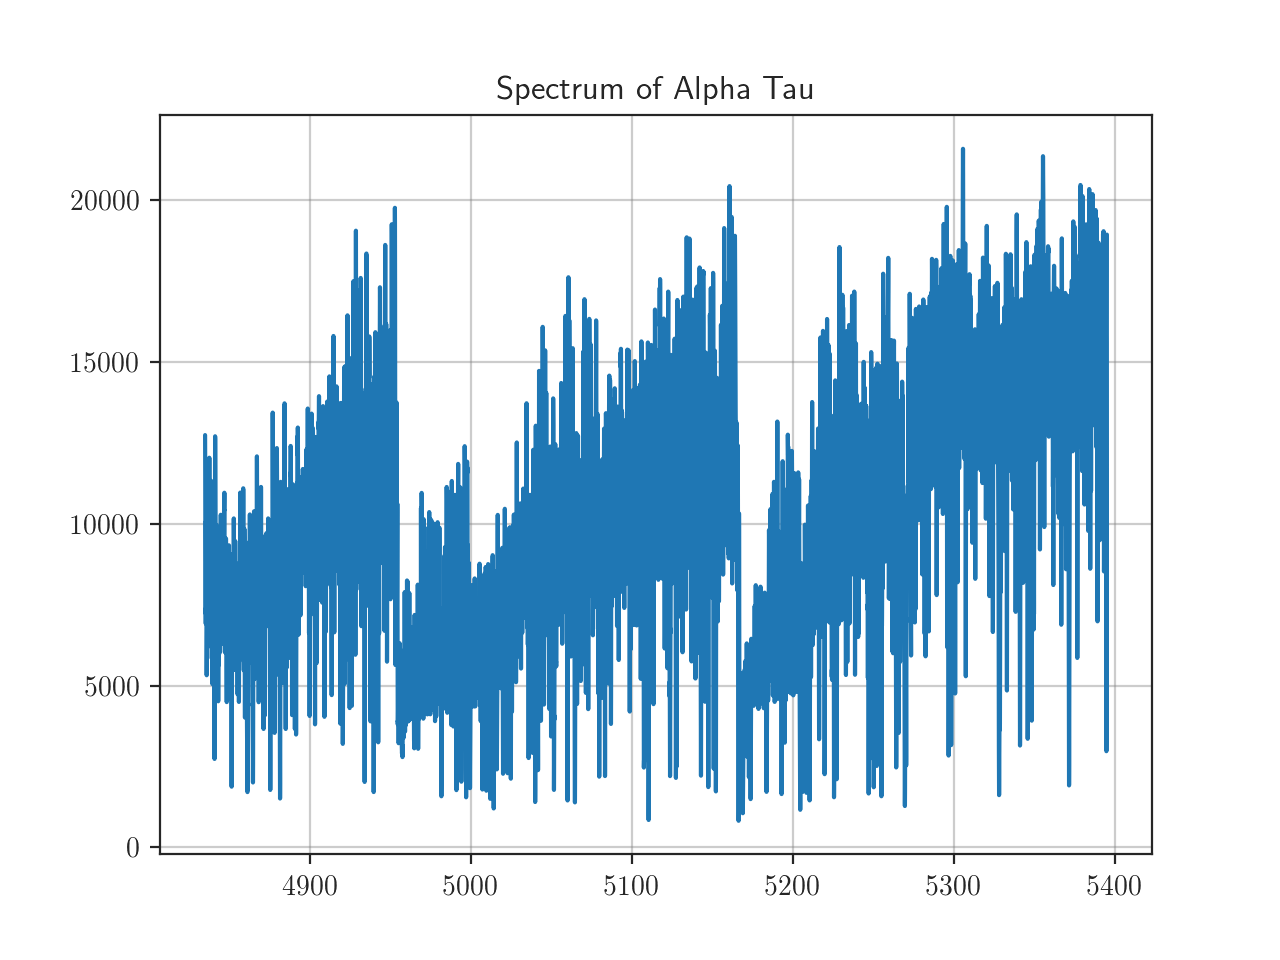

Text(0.5,1,'Spectrum of Alpha Tau')

In [257]:
%matplotlib notebook
plt.plot(wave_grid_uves, flux)
plt.title('Spectrum of Alpha Tau')

In [98]:
# Calculate statistics for the predictions
average_quadratic_diff_teff_MRD = np.nanmean(np.abs(MRD['Teff'] - MRD['StarNet Teff']))
average_quadratic_diff_logg_MRD = np.nanmean(np.abs(MRD['logg'] - MRD['StarNet logg']))
average_quadratic_diff_feh_MRD = np.nanmean(np.abs(MRD['[Fe/H]'] - MRD['StarNet [Fe/H]']))

average_quadratic_diff_teff_MRG = np.nanmean(np.abs(MRG['Teff'] - MRG['StarNet Teff']))
average_quadratic_diff_logg_MRG = np.nanmean(np.abs(MRG['logg'] - MRG['StarNet logg']))
average_quadratic_diff_feh_MRG = np.nanmean(np.abs(MRG['[Fe/H]'] - MRG['StarNet [Fe/H]']))

average_quadratic_diff_teff_MP = np.nanmean(np.abs(MP['Teff'] - MP['StarNet Teff']))
average_quadratic_diff_logg_MP = np.nanmean(np.abs(MP['logg'] - MP['StarNet logg']))
average_quadratic_diff_feh_MP = np.nanmean(np.abs(MP['[Fe/H]'] - MP['StarNet [Fe/H]']))

<IPython.core.display.Javascript object>


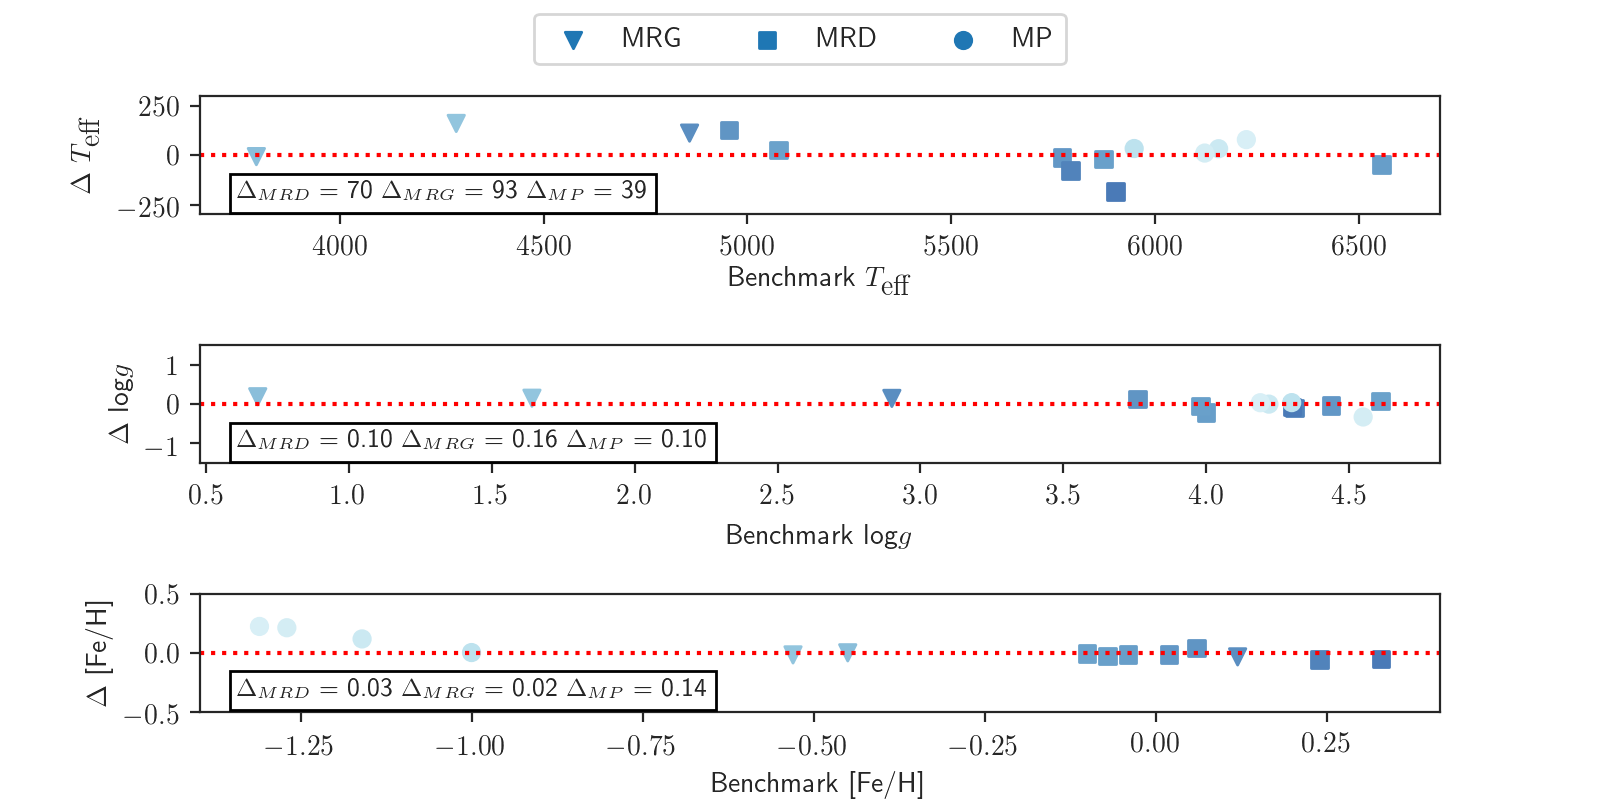

In [99]:
%matplotlib notebook
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1)
cm = plt.cm.get_cmap('RdYlBu')
fig = plt.figure(figsize=(8, 4)) 
gs = gridspec.GridSpec(3, 1,  width_ratios=[1])


ax = plt.subplot(gs[0,0])
sc = plt.scatter(MRG['Teff'], MRG['StarNet Teff'] - MRG['Teff'], marker="v", label='MRGs', 
                 c=MRG['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
sc = plt.scatter(MRD['Teff'], MRD['StarNet Teff'] - MRD['Teff'], marker="s", label='MRDs',
                 c=MRD['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
sc = plt.scatter(MP['Teff'], MP['StarNet Teff'] - MP['Teff'], marker="o", label='MPs',
                 c=MP['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
annotation = r'$\Delta_{{MRD}}=${0:6.0f}'.format(average_quadratic_diff_teff_MRD,width=6)
annotation += r' $\Delta_{{MRG}}=${0:6.0f}'.format(average_quadratic_diff_teff_MRG,width=6)
annotation += r' $\Delta_{{MP}}=${0:6.0f}'.format(average_quadratic_diff_teff_MP,width=6)
ax.annotate(annotation, xy=(0.03, 0.12), xycoords='axes fraction', fontsize=9, bbox=bbox_props)
plt.grid()
plt.axhline(y=0, color='r', linestyle=':')
plt.ylim((-300,300))
plt.xlabel(r'Benchmark $T_{\textrm{eff}}$')
plt.ylabel(r'$\Delta$ $T_{\textrm{eff}}$')


ax = plt.subplot(gs[1,0])
sc = plt.scatter(MRG['logg'], MRG['StarNet logg'] - MRG['logg'], marker="v", label='MRGs', 
                 c=MRG['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
sc = plt.scatter(MRD['logg'], MRD['StarNet logg'] - MRD['logg'], marker="s", label='MRDs', 
                 c=MRD['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
sc = plt.scatter(MP['logg'], MP['StarNet logg'] - MP['logg'], marker="o", label='MPs', 
                 c=MP['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
annotation = r'$\Delta_{{MRD}}=${0:6.2f}'.format(average_quadratic_diff_logg_MRD,width=6)
annotation += r' $\Delta_{{MRG}}=${0:6.2f}'.format(average_quadratic_diff_logg_MRG,width=6)
annotation += r' $\Delta_{{MP}}=${0:6.2f}'.format(average_quadratic_diff_logg_MP,width=6)
ax.annotate(annotation, xy=(0.03, 0.12), xycoords='axes fraction', fontsize=9, bbox=bbox_props)
plt.grid()
plt.axhline(y=0, color='r', linestyle=':')
plt.ylim((-1.5,1.5))
plt.xlabel(r'Benchmark log$g$')
plt.ylabel(r'$\Delta$ log$g$')


ax = plt.subplot(gs[2,0])
sc1 = plt.scatter(MRG['[Fe/H]'], MRG['StarNet [Fe/H]'] - MRG['[Fe/H]'], marker="v", label='MRGs', 
                 c=MRG['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
sc2 = plt.scatter(MRD['[Fe/H]'], MRD['StarNet [Fe/H]'] - MRD['[Fe/H]'], marker="s", label='MRDs', 
                 c=MRD['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
sc3 = plt.scatter(MP['[Fe/H]'], MP['StarNet [Fe/H]'] - MP['[Fe/H]'], marker="o", label='MPs', 
                 c=MP['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
annotation = r'$\Delta_{{MRD}}=${0:6.2f}'.format(average_quadratic_diff_feh_MRD,width=6)
annotation += r' $\Delta_{{MRG}}=${0:6.2f}'.format(average_quadratic_diff_feh_MRG,width=6)
annotation += r' $\Delta_{{MP}}=${0:6.2f}'.format(average_quadratic_diff_feh_MP,width=6)
ax.annotate(annotation, xy=(0.03, 0.12), xycoords='axes fraction', fontsize=9, bbox=bbox_props)
plt.grid()
plt.axhline(y=0, color='r', linestyle=':')
plt.ylim((-0.5,0.5))
plt.xlabel(r'Benchmark [Fe/H]')
plt.ylabel(r'$\Delta$ [Fe/H]')
fig.subplots_adjust(wspace=.05, hspace=1.1)
#fig.suptitle('MRGs and MRDs')

fig.legend((sc1, sc2, sc3), ('MRG', 'MRD', 'MP'), 'upper center', ncol=3)

In [28]:
def get_intrigoss_fitsname(teff, logg, feh, afe):
    # Construct the full INTRIGOSS .fits file name from stellar parameters
    if feh>0.:
        str_feh= 'ap{}{}'.format(int(feh),('%.2f' % (feh % 1))[2:4]) #int(round((feh % 1)*100.)))
    elif feh<0.:
        str_feh= 'am{}{}'.format(int(-feh),('%.2f' % (-feh % 1))[2:4]) #int(round((-feh % 1)*100.)))
    else:
        str_feh= 'ap000'
    if afe>0.:
        str_afe= 'alpp{}{}'.format(int(afe),('%.2f' % (afe % 1))[2:4])#int(round((afe % 1)*100.)))
    elif afe<0.:
        str_afe= 'alpm{}{}'.format(int(-afe),('%.2f' % (-afe % 1))[2:4])#int(round((-afe % 1)*100.)))
    else:
        str_afe= 'alpp000'
    str_logg = 'g%i%i' % (int(logg),int(round((logg % 1)*10.)))
    filename = '{}_{}_t{}{}_v1_f.fits'.format(str_afe, str_feh, teff, str_logg)
    
    return filename

In [29]:
def find_closest_intrigoss_match(teff, logg, feh, afe):
    # INTRIGOSS grid spacing
    teff_grid = np.arange(3750, 7001, 250)
    logg_grid = np.arange(0.5, 5.1, 0.5)
    feh_grid = np.arange(-1.0, 0.51, 0.25)
    afe_grid = np.arange(-0.25, 0.51, 0.25) 
    
    # Find closest parameter values
    match_teff = teff_grid[np.argmin(np.abs(teff - teff_grid))]
    match_logg = logg_grid[np.argmin(np.abs(logg - logg_grid))]
    match_feh = feh_grid[np.argmin(np.abs(feh - feh_grid))]
    match_afe = afe_grid[np.argmin(np.abs(afe - afe_grid))]
    
    return match_teff, match_logg, match_feh, match_afe

In [30]:
def get_intrigoss_spectrum(path):
    hdulist = pyfits.open(path)
    flux_data = hdulist[1].data
    param_data = hdulist[0].header
    wav = flux_data['wavelength']
    flux = flux_data['surface_flux']
    
    return wav, flux

In [31]:
def rebin_to_grid(wav, flux, new_wav):
    f_ = np.ones(len(wav))
    spec_ = spectrum.ArraySourceSpectrum(wave=wav, flux=flux)
    filt = spectrum.ArraySpectralElement(wav, f_, waveunits='angstrom')
    obs = observation.Observation(spec_, filt, binset=new_wav, force='taper')
    flux = obs.binflux
    
    return flux

In [33]:
spec_dir = '/vmstorage/projects/gaiaeso/spectra/intrigoss/raw/surfaceflux/'
starnames = []
intrigoss_starnet_spectra = []  # INTRIGOSS spectra using matched StarNet parameters
intrigoss_benchmark_spectra = []  # INTRIGOSS spectra using matched benchmark parameters
benchmark_spectra = [] # Benchmark spectra
teff_list = []
logg_list = []
feh_list = []
delta_teff_list = []
delta_logg_list = []
delta_feh_list = []

for index, star in MRD.iterrows():

    starname = star['ID']
    
    # Collect benchmark and StarNet stellar parameters
    t_benchmark = getattr(star, "Teff")
    g_benchmark = getattr(star, "logg")
    f_benchmark = getattr(star, "[Fe/H]")
    t_starnet = getattr(star, "StarNet Teff")
    g_starnet = getattr(star, "StarNet logg")
    f_starnet = getattr(star, "StarNet [Fe/H]")
    a_starnet = getattr(star, "StarNet [alpha/M]")
    
    # Find the closest match in the INTRIGOSS grid for benchmark parameters (teff, logg, and [Fe/H], setting [alpha/Fe]=StarNet[alpha/Fe])
    match_teff_benchmark, match_logg_benchmark, \
    match_feh_benchmark, match_afe_benchmark = find_closest_intrigoss_match(t_benchmark, g_benchmark, f_benchmark, a_starnet)

    # Find the closest match in the INTRIGOSS grid for starnet parameters (teff, logg, [Fe/H], and [alpha/Fe])
    match_teff_starnet, match_logg_starnet, \
    match_feh_starnet, match_afe_starnet = find_closest_intrigoss_match(t_starnet, g_starnet, f_starnet, a_starnet)

    # Construct full string for the INTRIGOSS .fits files
    spec_filename_benchmark = get_intrigoss_fitsname(match_teff_benchmark, 
                                                     match_logg_benchmark, 
                                                     match_feh_benchmark,
                                                     match_afe_benchmark)
    spec_filename_starnet = get_intrigoss_fitsname(match_teff_starnet,
                                                   match_logg_starnet,
                                                   match_feh_starnet,
                                                   match_afe_starnet)
    
    print match_afe_benchmark, match_feh_benchmark, match_teff_benchmark, match_logg_benchmark
    print spec_filename_benchmark
    
    # Collect INTRIGOSS spectrum for matched benchmark and starnet parameters
    wav_intrigoss, flux_intri_bench = get_intrigoss_spectrum(spec_dir+spec_filename_benchmark)
    wav_intrigoss, flux_intri_starnet = get_intrigoss_spectrum(spec_dir+spec_filename_starnet)
    
    # Collect benchmark star spectrum
    x = np.loadtxt(benchmarks_folder + '%s_47000.txt' % star['ID'], skiprows=1)
    wave_benchmark, flux_benchmark = x[:,0], x[:,1]
    wave_benchmark*=10.  # Convert to angstroms

    # Degrade resolution
    err = np.zeros(len(flux_intri_bench))
    _, flux_intri_bench, _ = convolve_spectrum(wav_intrigoss, flux_intri_bench, err, to_resolution=47000)
    _, flux_intri_starnet, _ = convolve_spectrum(wav_intrigoss, flux_intri_starnet, err, to_resolution=47000)
    
    # Rebin to UVES wave grid
    flux_intri_bench = rebin_to_grid(wav_intrigoss, flux_intri_bench, wave_grid_uves)
    flux_intri_starnet = rebin_to_grid(wav_intrigoss, flux_intri_starnet, wave_grid_uves)
    flux_benchmark = rebin_to_grid(wave_benchmark, flux_benchmark, wave_grid_uves)

    # Continuum normalize the spectra
    flux_intri_bench, _, _ = continuum_normalize(flux_intri_bench, line_regions, segments, wave_grid_uves, False, 0)
    flux_intri_starnet, _, _ = continuum_normalize(flux_intri_starnet, line_regions, segments, wave_grid_uves, False, 0)
    flux_benchmark, _, _ = continuum_normalize(flux_benchmark, line_regions, segments, wave_grid_uves, False, 0)

    # Mask telluric lines
    flux_intri_bench = mask_tellurics('telluric_lines.txt', flux_intri_bench, wave_grid_uves)
    flux_intri_starnet = mask_tellurics('telluric_lines.txt', flux_intri_starnet, wave_grid_uves)
    flux_benchmark = mask_tellurics('telluric_lines.txt', flux_benchmark, wave_grid_uves)
    
    # Store spectra and name of star
    intrigoss_benchmark_spectra.append(flux_intri_bench)
    intrigoss_starnet_spectra.append(flux_intri_starnet)
    benchmark_spectra.append(flux_benchmark)
    starnames.append(starname)
    
    teff_list.append(t_benchmark)
    logg_list.append(g_benchmark)
    feh_list.append(f_benchmark)
    delta_teff_list.append(t_starnet - t_benchmark)
    delta_logg_list.append(g_starnet - g_benchmark)
    delta_feh_list.append(f_starnet - f_benchmark)

0.0 0.0 6500 4.0
alpp000_ap000_t6500g40_v1_f.fits
0.0 0.0 5750 4.5
alpp000_ap000_t5750g45_v1_f.fits
0.0 0.0 5750 4.0
alpp000_ap000_t5750g40_v1_f.fits
0.0 0.0 5000 4.0
alpp000_ap000_t5000g40_v1_f.fits
0.0 0.0 5000 4.5
alpp000_ap000_t5000g45_v1_f.fits
0.0 0.25 6000 4.5
alpp000_ap025_t6000g45_v1_f.fits


In [39]:
starnames[0][5:]

'Procyon-2'

<IPython.core.display.Javascript object>


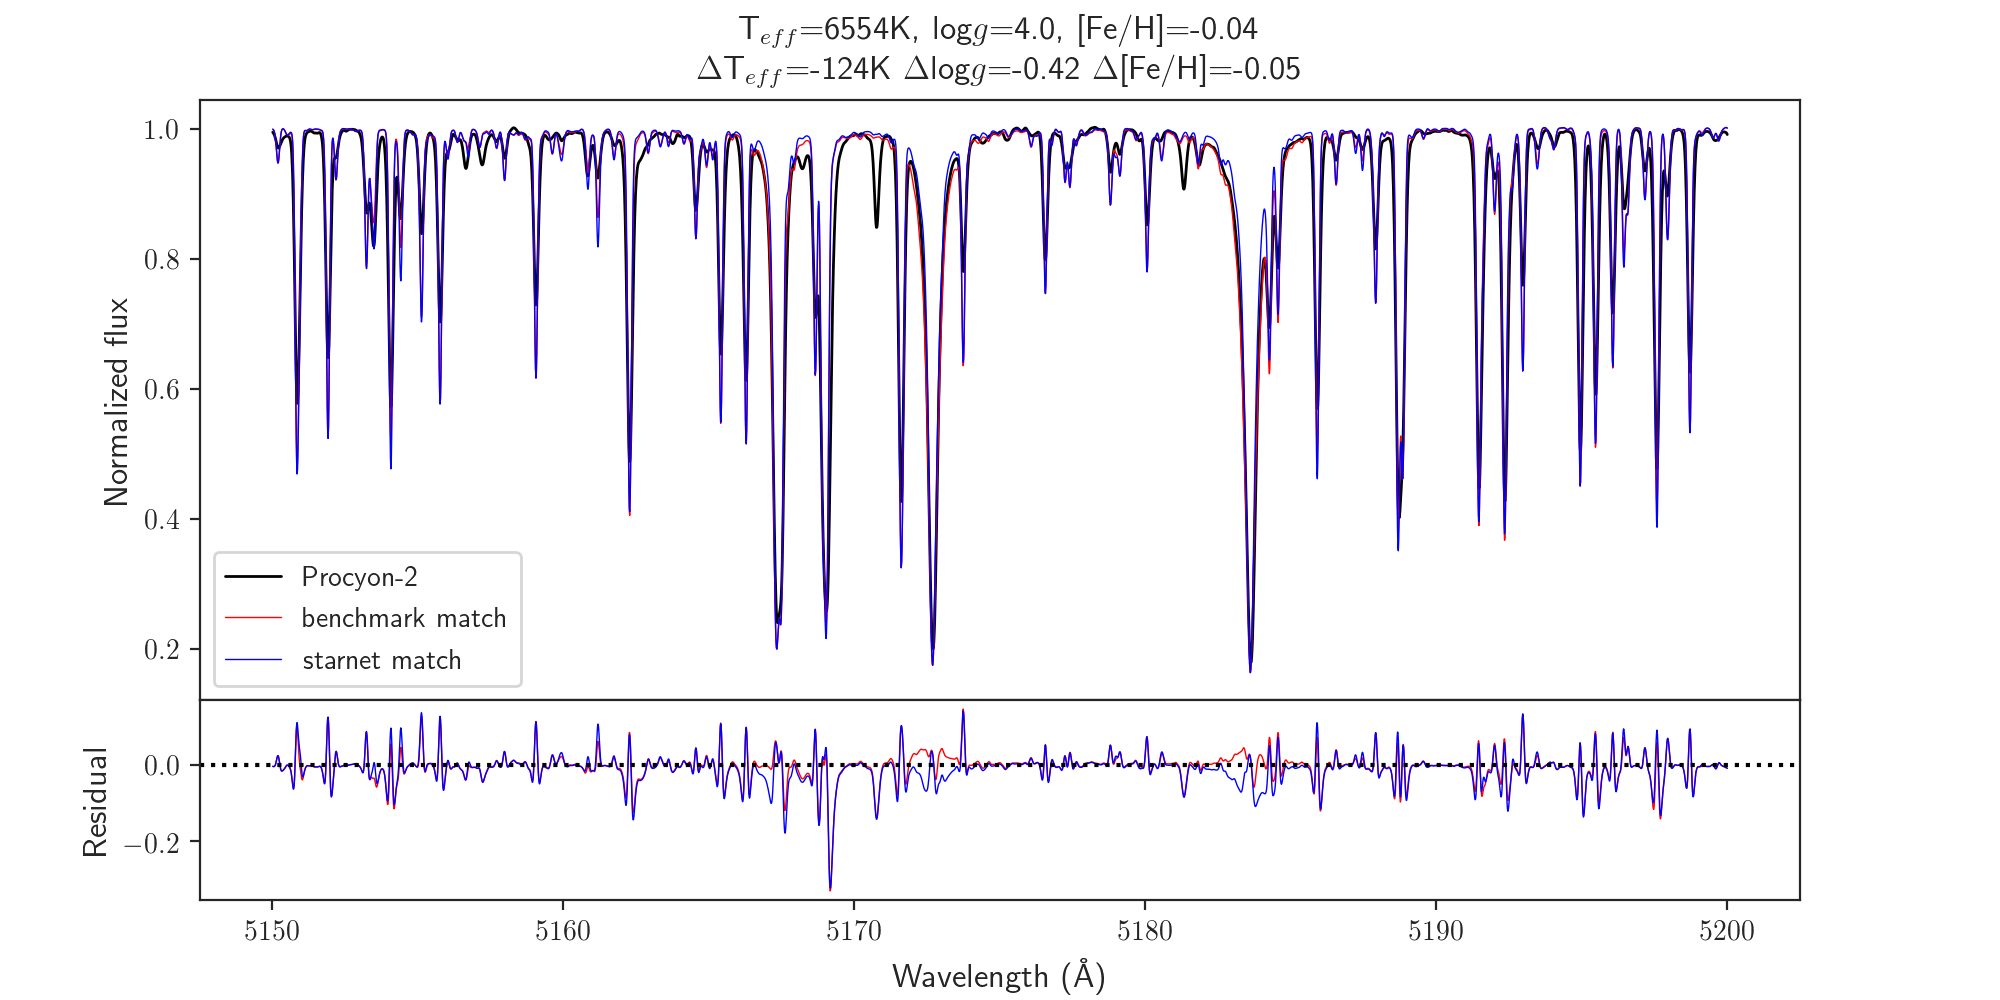

TAE benchmark: 747.7236705376883
TAE starnet: 805.3393885602394
MAE benchmark: 0.007871725276097918
MAE starnet: 0.00839206294671313


<IPython.core.display.Javascript object>


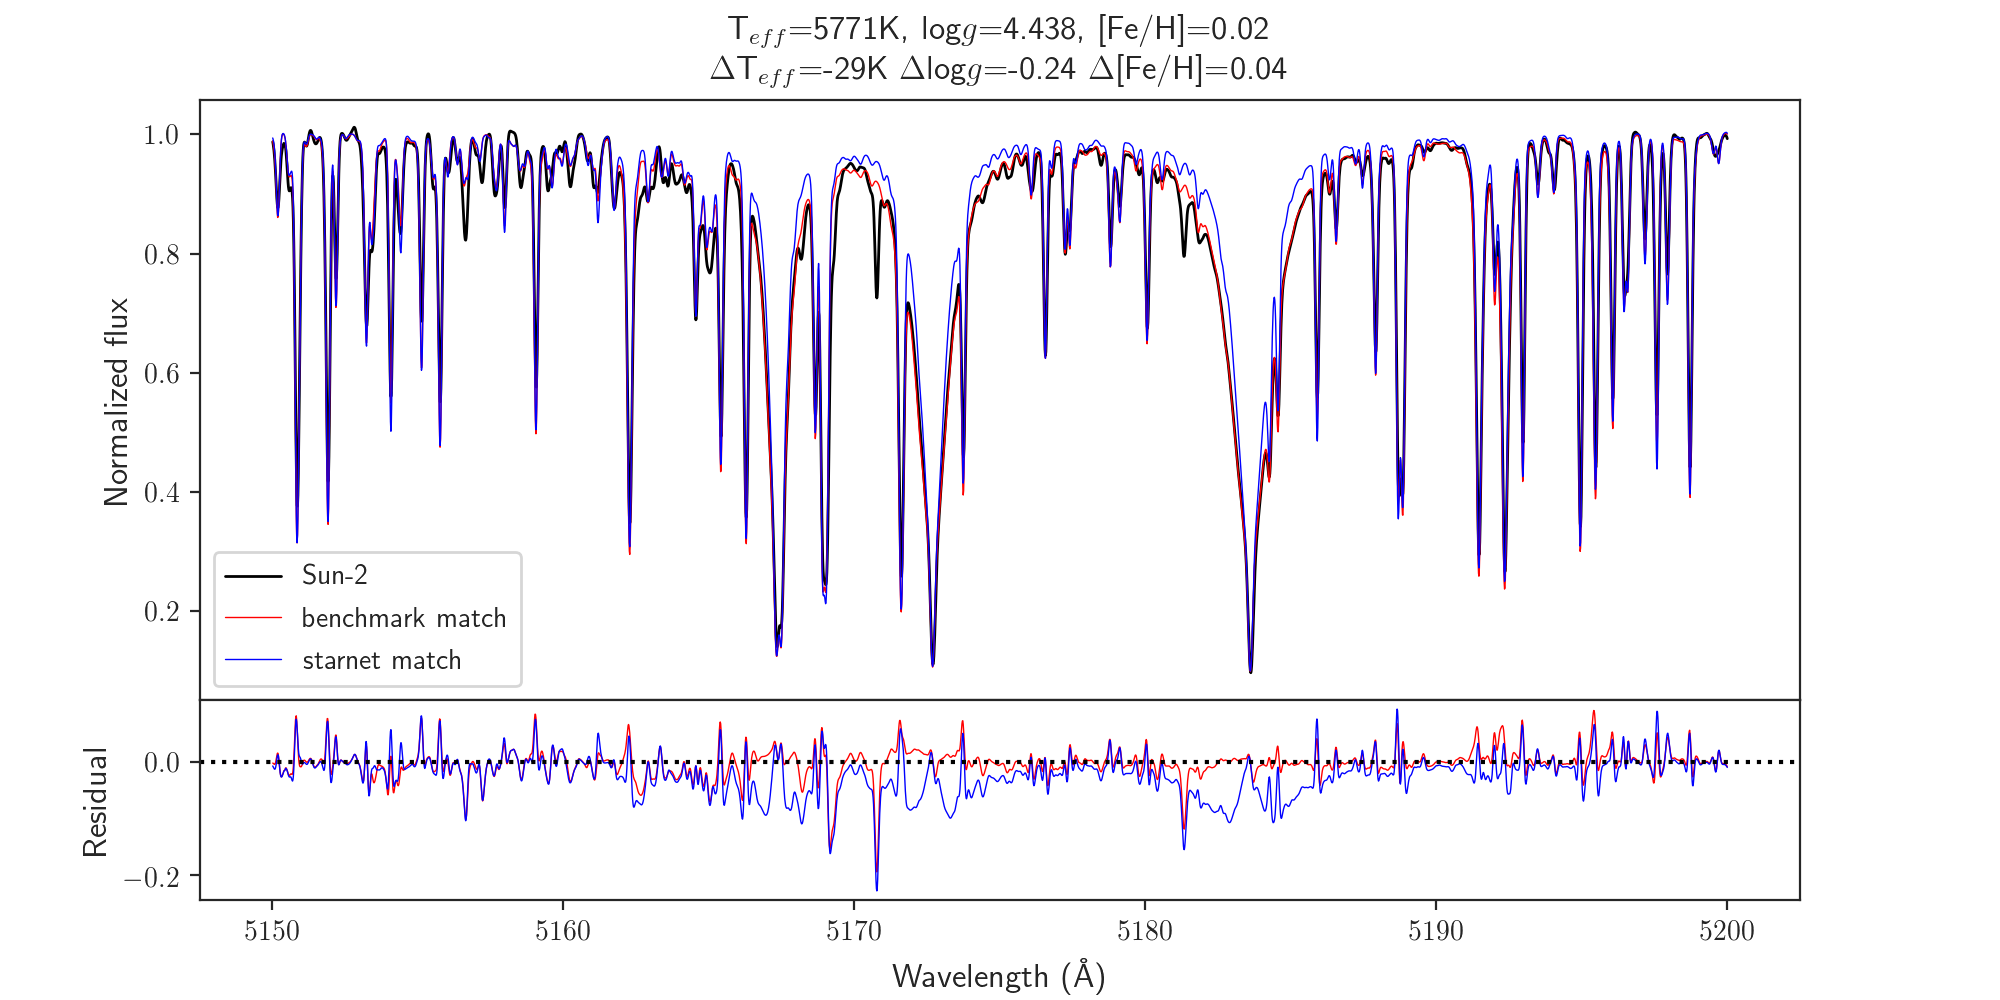

TAE benchmark: 619.7320457927619
TAE starnet: 764.4357619481011
MAE benchmark: 0.008889709403467616
MAE starnet: 0.01111401358190961


<IPython.core.display.Javascript object>


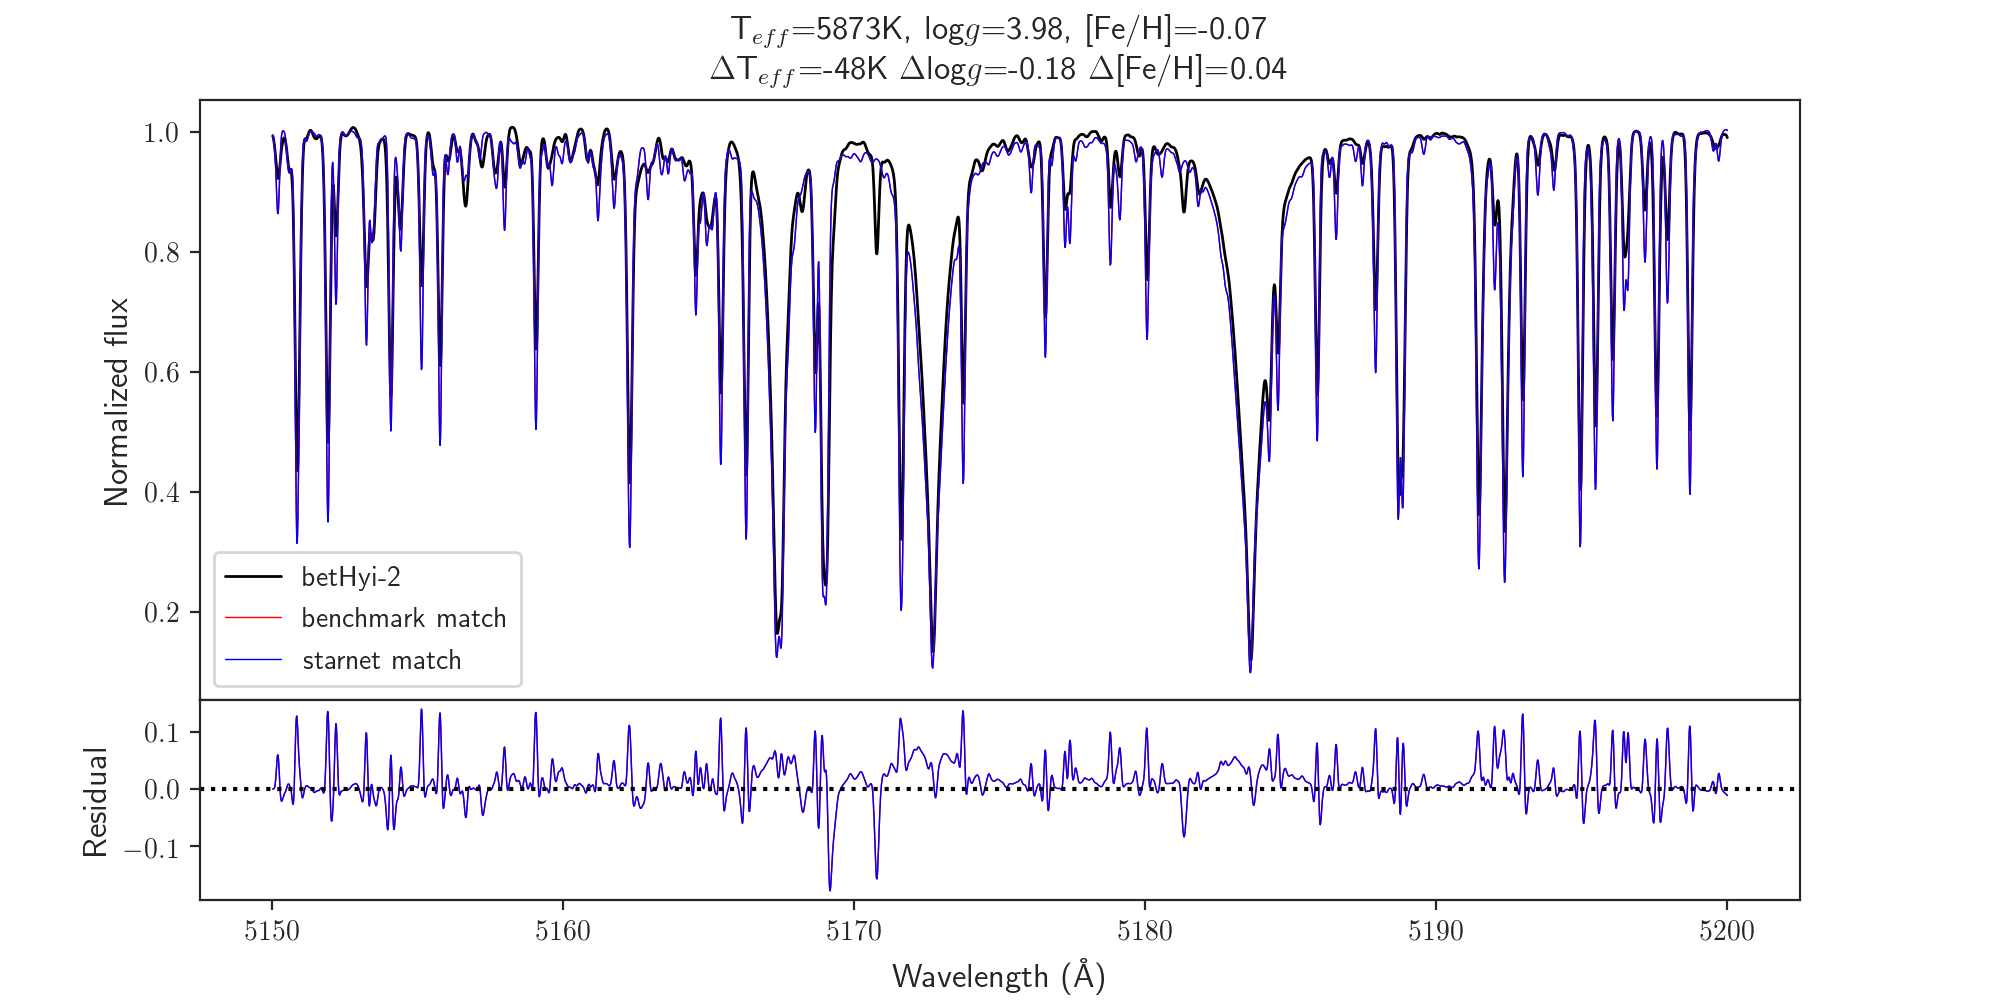

TAE benchmark: 793.021738567283
TAE starnet: 793.021738567283
MAE benchmark: 0.009351612896940587
MAE starnet: 0.009351612896940587


<IPython.core.display.Javascript object>


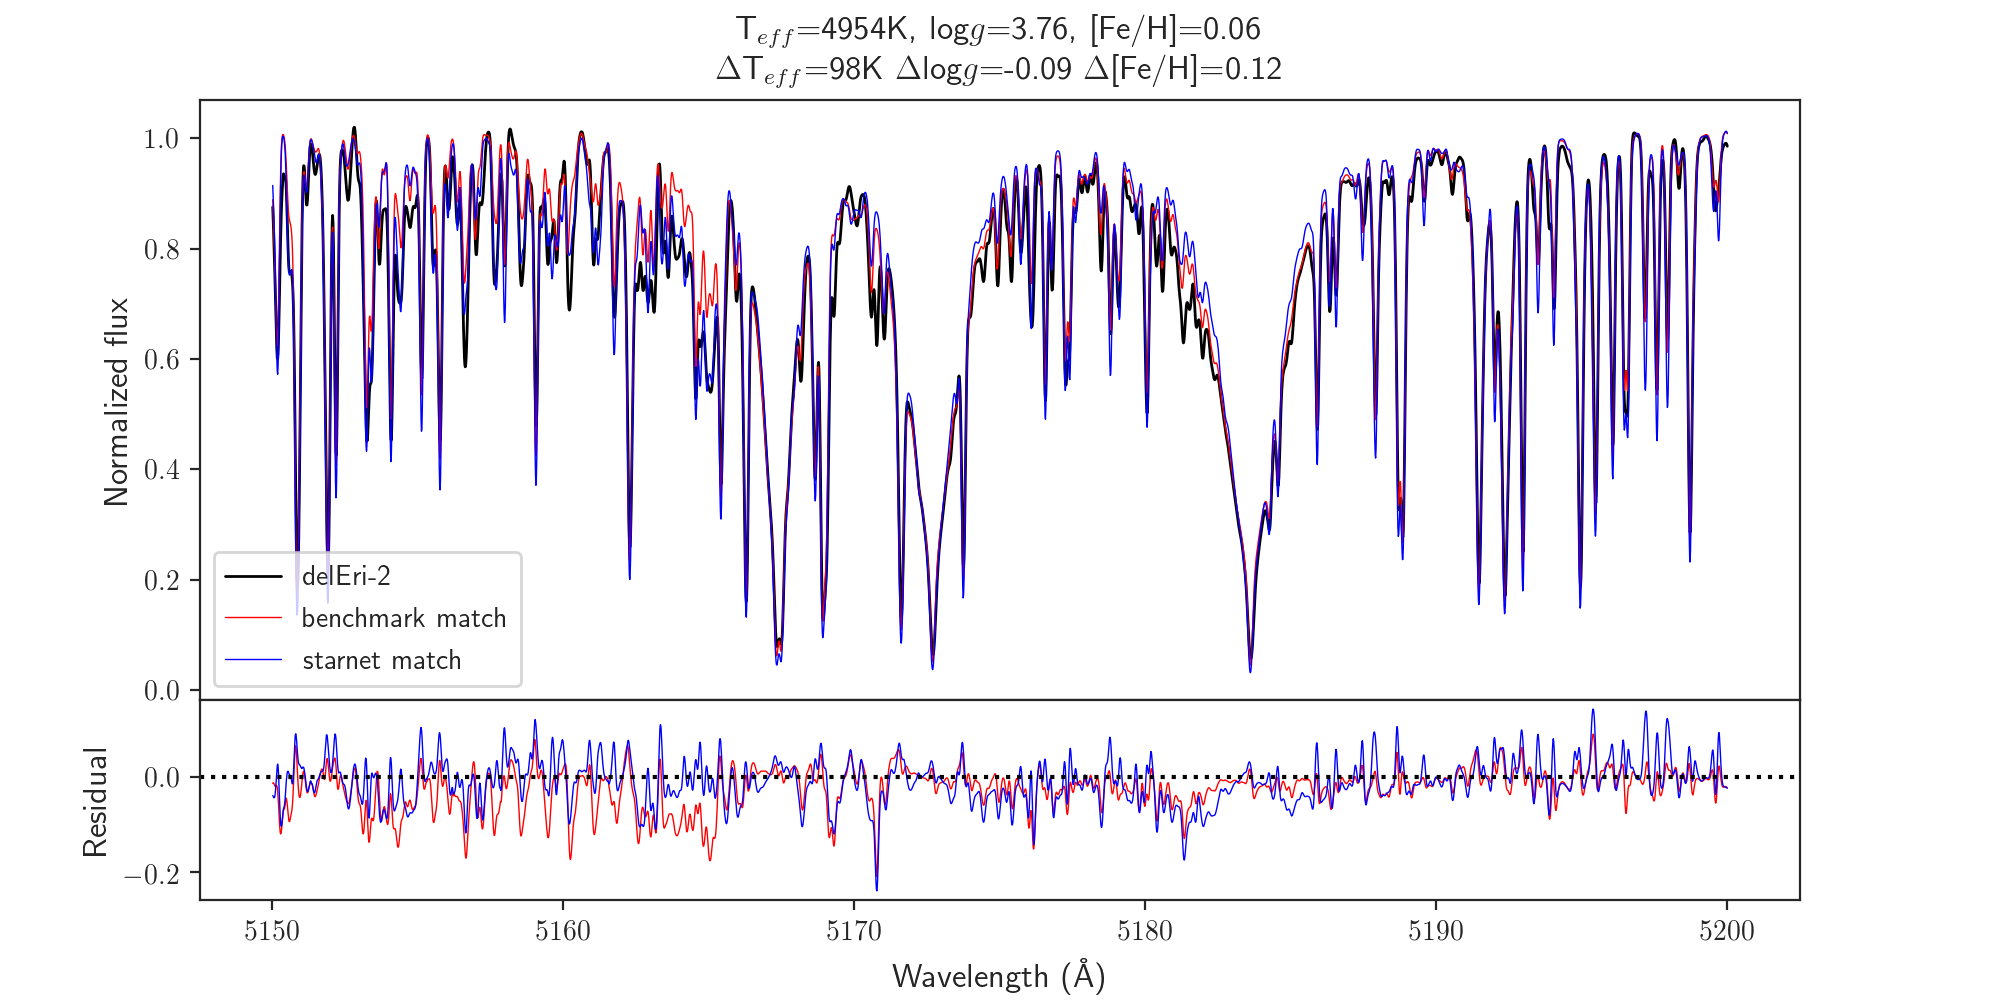

TAE benchmark: 1199.9548772064318
TAE starnet: 1257.7906497967272
MAE benchmark: 0.019962928896624432
MAE starnet: 0.022254646102719378


<IPython.core.display.Javascript object>


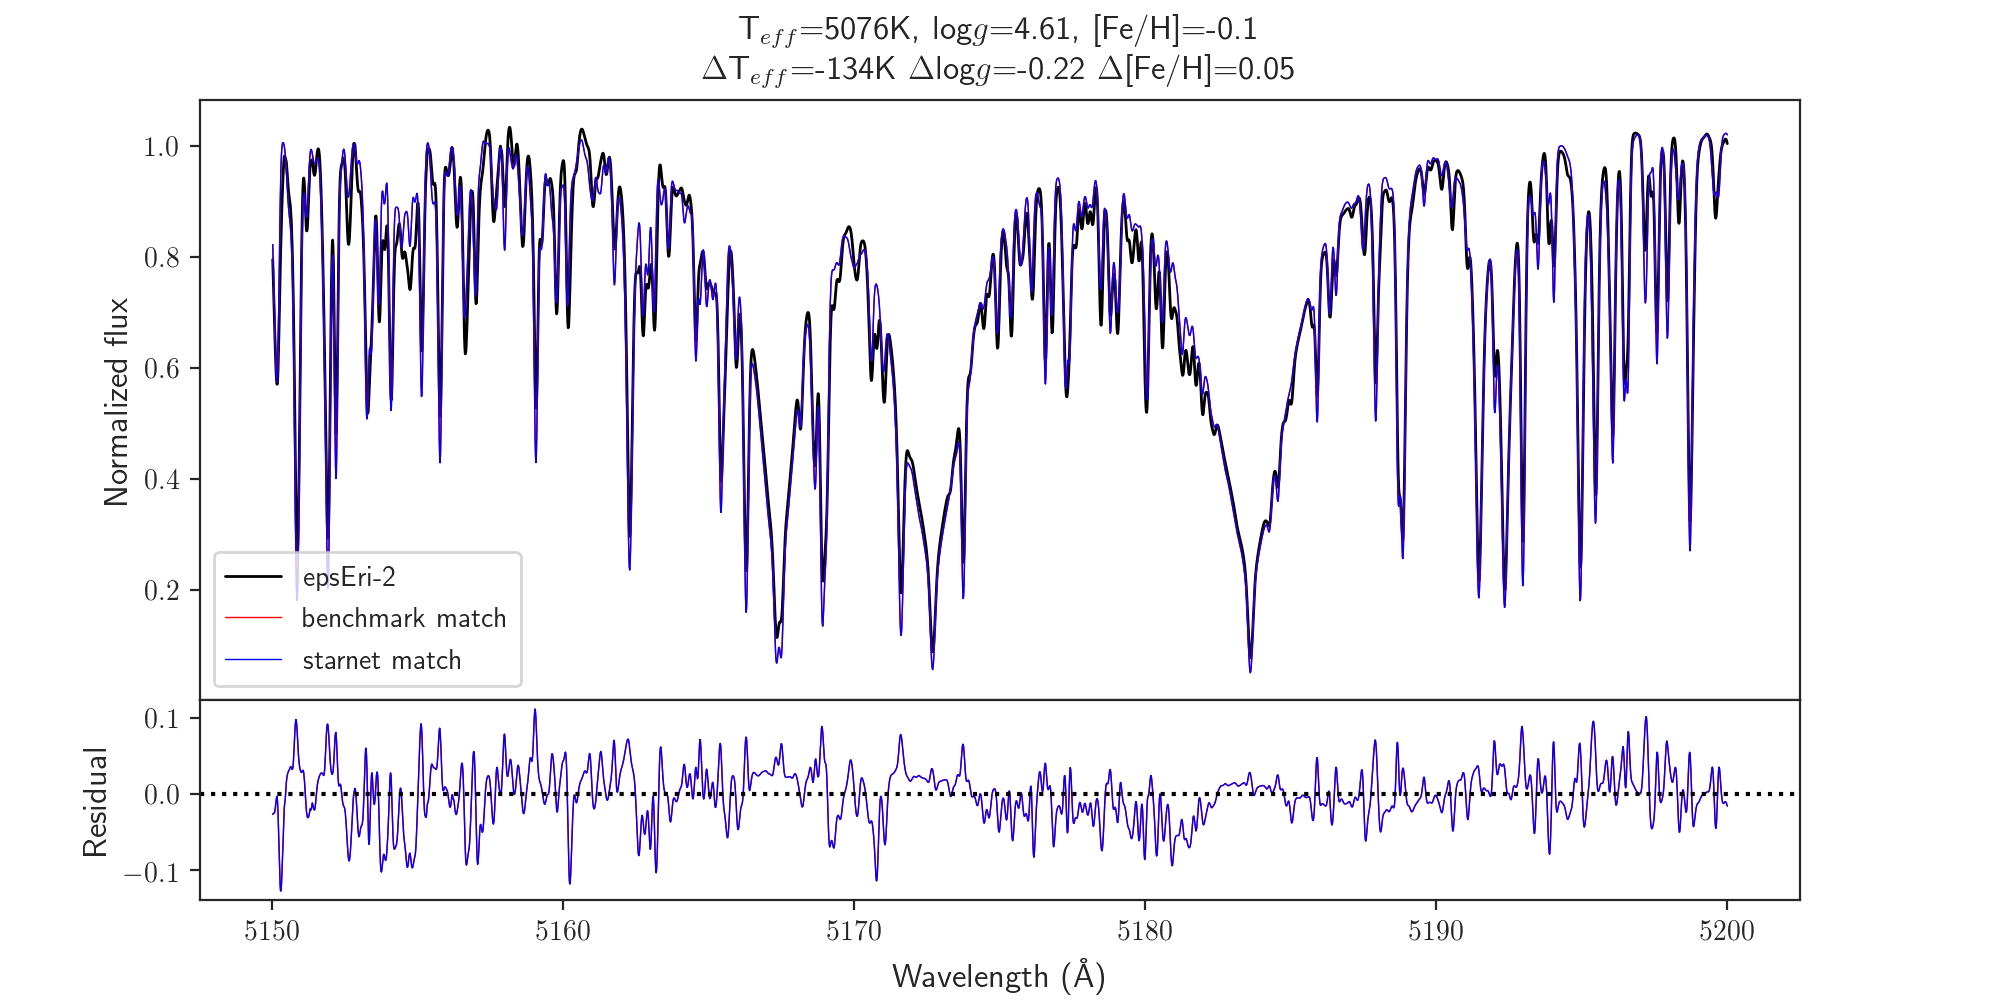

TAE benchmark: 1016.4712060140758
TAE starnet: 1016.4712060140758
MAE benchmark: 0.017830309957093393
MAE starnet: 0.017830309957093393


<IPython.core.display.Javascript object>


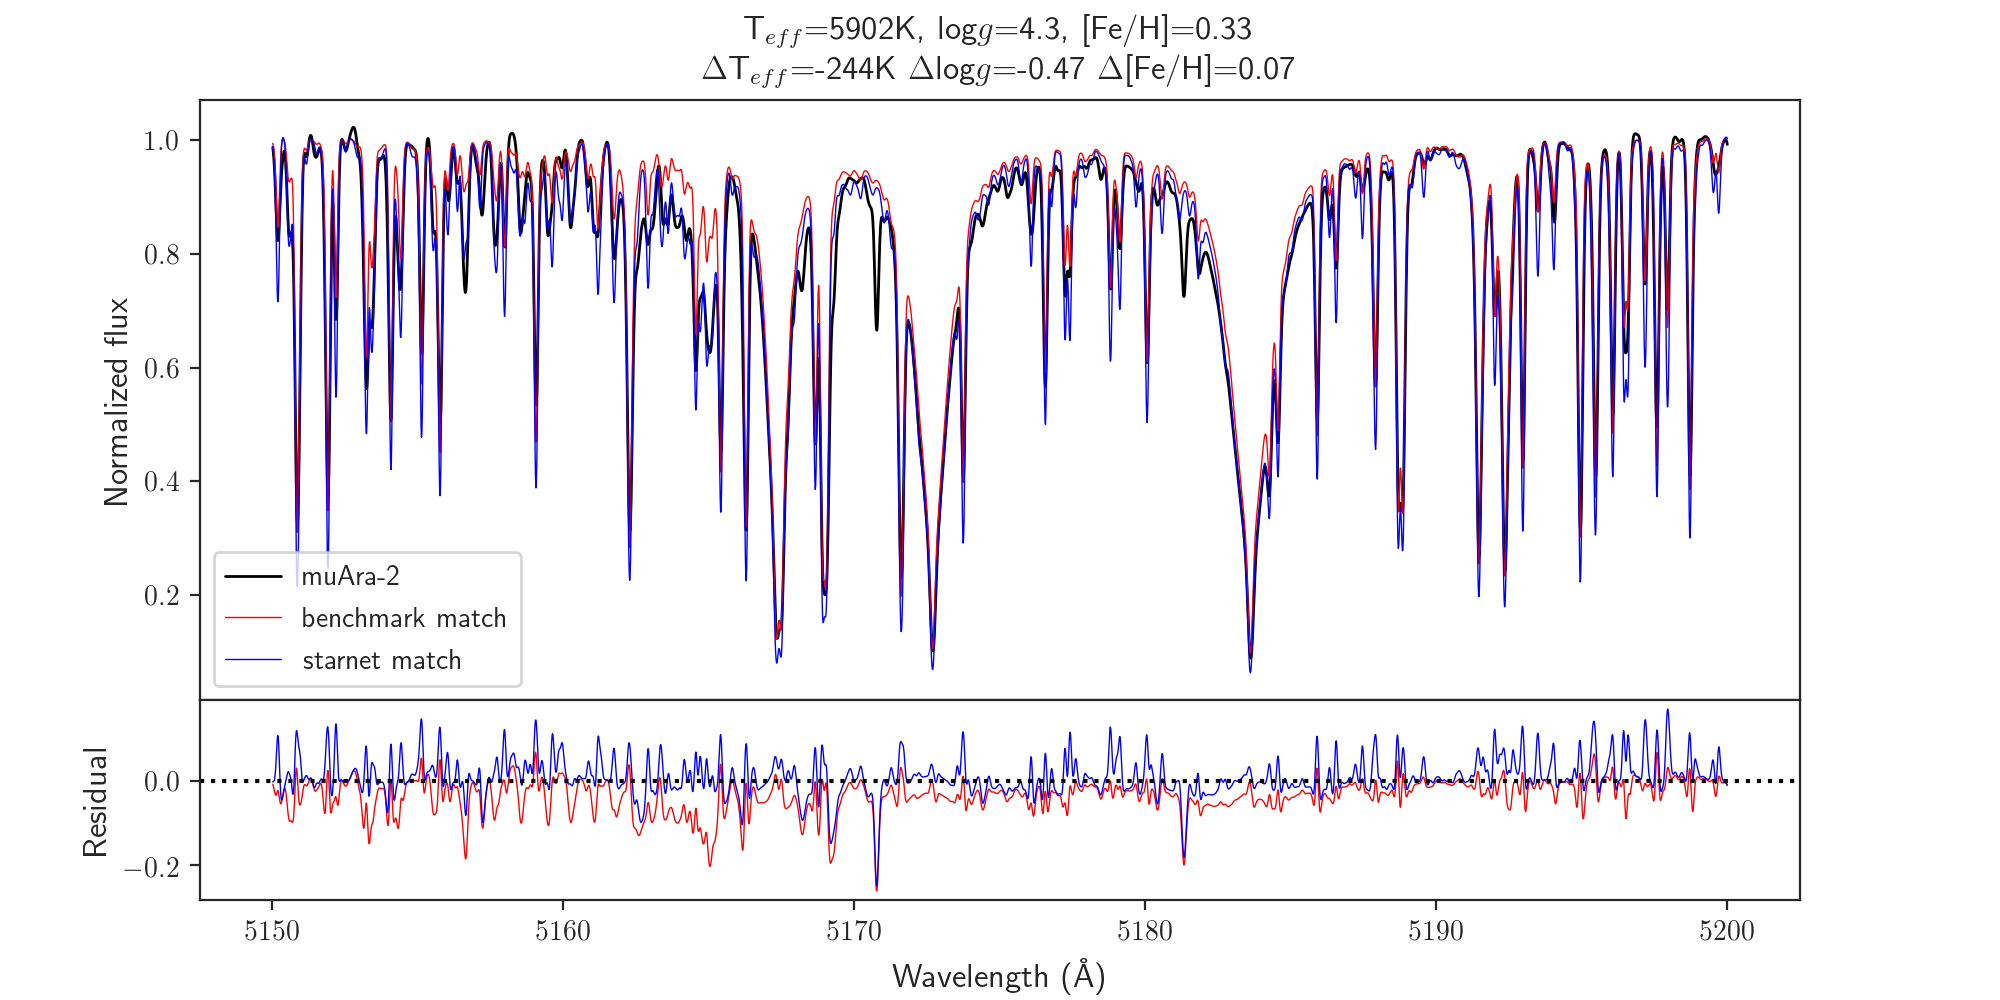

TAE benchmark: 1279.5599254384729
TAE starnet: 1211.0517012399625
MAE benchmark: 0.022300557203175808
MAE starnet: 0.018976903970865266


In [40]:
%matplotlib notebook

wavemin = 5150
wavemax = 5200
indices = (wave_grid_uves > wavemin) & (wave_grid_uves < wavemax)

TAE_starnet = 0
TAE_benchmark = 0
MAE_starnet = []
MAE_benchmark = []

for i in range(len(benchmark_spectra)):
    
    fig1 = plt.figure(figsize=(10,5))
    
    #Plot Data-model
    frame1=fig1.add_axes((.1,.3,.8,.6))
    #xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
    plt.plot(wave_grid_uves[indices], benchmark_spectra[i][indices], lw=1, color='black', label=str(starnames[i][5:])) 
    plt.plot(wave_grid_uves[indices], intrigoss_benchmark_spectra[i][indices], lw=0.5, color='red', label='benchmark match')
    plt.plot(wave_grid_uves[indices], intrigoss_starnet_spectra[i][indices], lw=0.5, color='blue', label='starnet match')
    plt.legend(loc=0)
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    plt.grid()
    plt.ylabel('Normalized flux', fontsize=12)
    title = r"T$_{eff}$=%sK,   log$g$=%s,   [Fe/H]=%s" % (teff_list[i], logg_list[i], feh_list[i]) + "\n" + \
                r"$\Delta$T$_{eff}$=%sK   $\Delta$log$g$=%.2f   $\Delta$[Fe/H]=%.2f" % \
                    (delta_teff_list[i], delta_logg_list[i], delta_feh_list[i])
    plt.title(title, fontsize = 12)

    #Residual plot
    difference1 = benchmark_spectra[i] - intrigoss_benchmark_spectra[i]
    difference2 = benchmark_spectra[i] - intrigoss_starnet_spectra[i]
    frame2=fig1.add_axes((.1,.1,.8,.2))        
    plt.plot(wave_grid_uves[indices],difference1[indices], lw=0.5, color='red')
    plt.plot(wave_grid_uves[indices],difference2[indices], lw=0.5, color='blue')
    plt.axhline(y=0, color='black', linestyle=':')
    plt.grid()
    plt.xlabel(r'Wavelength (\r{A})', fontsize=12)
    plt.ylabel('Residual', fontsize=12)
    plt.show()
    
    TAE_starnet += np.sum(np.abs(difference2))
    TAE_benchmark += np.sum(np.abs(difference1))
    MAE_starnet.append(np.median(np.abs(difference2)))
    MAE_benchmark.append(np.median(np.abs(difference1)))
    print 'TAE benchmark: %s' % np.sum(np.abs(difference1))
    print 'TAE starnet: %s' % np.sum(np.abs(difference2))
    print 'MAE benchmark: %s' % np.median(np.abs(difference1))
    print 'MAE starnet: %s' % np.median(np.abs(difference2))

In [4]:
# Plot MgII region, 5150A - 5200A

In [358]:
difference1

array([0.02126759, 0.02159098, 0.02181236, ..., 0.00140955, 0.00135337,
       0.00102949])

In [220]:
print np.mean(MAE_benchmark)
print np.mean(MAE_starnet)

0.024695636619233012
0.025473456095330128


In [213]:
benchmark_stars = \
{# F dwarfs 
'Procyon': {'teff': 6554, 'logg': 4.0, 'fe_h': 0.01, 'filename': 'UVES_Procyon-1_47000', 'teff_flag': 0, 'logg_flag': 0},
'HD 84937': {'teff': 6356, 'logg': 4.06, 'fe_h': -2.03, 'filename': 'UVES_HD84937-1_47000', 'teff_flag': 0, 'logg_flag': 0},
'HD 49933': {'teff': 6635, 'logg': 4.20, 'fe_h': -0.41, 'filename': None, 'teff_flag': 0, 'logg_flag': 0},
# FGK subgiants
'delta Eri': {'teff': 4954, 'logg': 3.76, 'fe_h': 0.06, 'filename': 'UVES_delEri-1_47000', 'teff_flag': 0, 'logg_flag': 0},
'HD 140283': {'teff': 5522, 'logg': 3.58, 'fe_h': -2.36, 'filename': 'UVES_HD140283-1_47000', 'teff_flag': 1, 'logg_flag': 0},
'epsilon For': {'teff': 5123, 'logg': 3.52, 'fe_h': -0.6, 'filename': None, 'teff_flag': 0, 'logg_flag': 1},
'eta Boo': {'teff': 6099, 'logg': 3.79, 'fe_h': 0.32, 'filename': None, 'teff_flag': 0, 'logg_flag': 0},
'beta Hyi': {'teff': 5873, 'logg': 3.98, 'fe_h': -0.04, 'filename': 'UVES_betHyi-1_47000', 'teff_flag': 0, 'logg_flag': 0},
# G dwarfs
'alpha Cen A': {'teff': 5792, 'logg': 4.31, 'fe_h': 0.26, 'filename': 'UVES_alfCenA-1_47000', 'teff_flag': 0, 'logg_flag': 0},
'HD 22879': {'teff': 5868, 'logg': 4.27, 'fe_h': -0.86, 'filename': None, 'teff_flag': 0, 'logg_flag': 0},
'Sun': {'teff': 5771, 'logg': 4.4380, 'fe_h': 0.03, 'filename': 'UVES_Sun-1_47000', 'teff_flag': 0, 'logg_flag': 0},
'mu Cas': {'teff': 5308, 'logg': 4.41, 'fe_h': -0.81, 'filename': None, 'teff_flag': 0, 'logg_flag': 1},
'tau Cet': {'teff': 5414, 'logg': 4.49, 'fe_h': -0.49, 'filename': None, 'teff_flag': 0, 'logg_flag': 1},
'alpha Cen B': {'teff': 5231, 'logg': 4.53, 'fe_h': 0.22, 'filename': None, 'teff_flag': 0, 'logg_flag': 0},
'18 Sco': {'teff': 5810, 'logg': 4.44, 'fe_h': 0.03, 'filename': None, 'teff_flag': 0, 'logg_flag': 0},
'mu Ara': {'teff': 5902, 'logg': 4.30, 'fe_h': 0.35, 'filename': 'UVES_muAra-1_47000', 'teff_flag': 1, 'logg_flag': 0},
'beta Vir': {'teff': 6083, 'logg': 4.10, 'fe_h': 0.24, 'filename': None, 'teff_flag': 0, 'logg_flag': 0},
# FGK giants
'Arcturus': {'teff': 4286, 'logg': 1.64, 'fe_h': -0.52, 'filename': 'UVES_Arcturus-1_47000', 'teff_flag': 0, 'logg_flag': 1},
'HD 122563': {'teff': 4587, 'logg': 1.61, 'fe_h': -2.64, 'filename': 'UVES_HD122563-1_47000', 'teff_flag': 0, 'logg_flag': 0},
'mu Leo': {'teff': 4474, 'logg': 2.51, 'fe_h': 0.25, 'filename': None, 'teff_flag': 0, 'logg_flag': 0},
'beta Gem': {'teff': 4858, 'logg': 2.90, 'fe_h': 0.13, 'filename': 'UVES_betGem_47000', 'teff_flag': 0, 'logg_flag': 0},
'epsilon Vir': {'teff': 4983, 'logg': 2.77, 'fe_h': 0.15, 'filename': None, 'teff_flag': 0, 'logg_flag': 0},
'zeta Hya': {'teff': 5044, 'logg': 2.87, 'fe_h': 0.16, 'filename': None, 'teff_flag': 0, 'logg_flag': 0},
'HD 107328': {'teff': 4496, 'logg': 2.09, 'fe_h': -0.33, 'filename': None, 'teff_flag': 0, 'logg_flag': 0},
'HD 220009': {'teff': 4217, 'logg': 1.43, 'fe_h': -0.74, 'filename': None, 'teff_flag': 1, 'logg_flag': 1},
# M giants
'alpha Tau': {'teff': 3927, 'logg': 1.11, 'fe_h': -0.37, 'filename': 'UVES_alfTau_47000', 'teff_flag': 0, 'logg_flag': 0},
'alpha Cet': {'teff': 3796, 'logg': 0.68, 'fe_h': -0.45, 'filename': 'UVES_alfCet-1_47000', 'teff_flag': 0, 'logg_flag': 0},
'beta Ara': {'teff': 4197, 'logg': 1.05, 'fe_h': -0.05, 'filename': None, 'teff_flag': 1, 'logg_flag': 1},
'gamma Sge': {'teff': 3807, 'logg': 1.05, 'fe_h': -0.17, 'filename': None, 'teff_flag': 0, 'logg_flag': 0},
'psi Phe': {'teff': 3472, 'logg': 0.51, 'fe_h': -1.24, 'filename': 'UVES_psiPhe_47000', 'teff_flag': 1, 'logg_flag': 1},
# K dwarfs
'epsilon Eri': {'teff': 5076, 'logg': 4.61, 'fe_h': -0.09, 'filename': 'UVES_epsEri-1_47000', 'teff_flag': 0, 'logg_flag': 0},
'Gmb 1830': {'teff': 4827, 'logg': 4.60, 'fe_h': -1.46, 'filename': None, 'teff_flag': 1, 'logg_flag': 0},
'61 Cyg A': {'teff': 4374, 'logg': 4.63, 'fe_h': -0.33, 'filename': None, 'teff_flag': 0, 'logg_flag': 0},
'61 Cyg B': {'teff': 4044, 'logg': 4.67, 'fe_h': -0.38, 'filename': None, 'teff_flag': 0, 'logg_flag': 0}
}

In [ ]:
import warnings
warnings.filterwarnings("ignore")
benchmarks_folder = '/home/spiffical/data/spiffical/gaia-ESO/benchmark-stars/'
fluxes_norm = []
fluxes_nonorm = []
continuums = []
for star in benchmark_stars:
    bms = benchmark_stars[star]
    if bms['filename'] is None:
        bms['starnet_teff'] = np.nan
        bms['starnet_logg'] = np.nan
        bms['starnet_feh'] = np.nan
        bms['starnet_alpha'] = np.nan
    else:
        print star
        # Load .txt file containing wavelength and flux arrays
        x = np.loadtxt(benchmarks_folder + '%s.txt' % bms['filename'], skiprows=1)
        wave, flux = x[:,0], x[:,1]
        wave*=10.  # Convert to angstroms
        
        # Rebin to UVES grid
        f_ = np.ones(len(wave))
        spec_ = spectrum.ArraySourceSpectrum(wave=wave, flux=flux)
        filt = spectrum.ArraySpectralElement(wave, f_, waveunits='angstrom')
        obs = observation.Observation(spec_, filt, binset=wave_grid_uves, force='taper')
        flux = obs.binflux
        
        fluxes_nonorm.append(flux)
        # Continuum normalize the spectrum
        flux, _, cont = continuum_normalize(flux, line_regions, segments, wave_grid_uves, 
                                            multiprocess=False)
        continuums.append(cont)
        fluxes_norm.append(flux)
        
        # Mask telluric lines
        flux = mask_tellurics('telluric_lines.txt', flux, wave_grid)
        flux[flux>1.03]=0
        flux[flux<0]=0
        
        # Reshape data for compatibility with neural network
        X = np.reshape(flux, (np.shape(np.atleast_2d(flux))[0], np.shape(np.atleast_2d(flux))[1], 1))

        # Predict on spectra
        test_pred = model.predict(X, batch_size=1, verbose=0)
        test_pred = data.denormalize(test_pred)
        
        # Add [Fe/H] flag if benchmark value is outside range of INTRIGOSS grid
        if bms['fe_h'] < -1.0 or bms['fe_h'] > 0.5:
            bms['fe_h_flag'] = 1
        
        # Add StarNet predictions to dictionary
        bms['starnet_teff'] = int(test_pred[0][0])
        bms['delta_teff'] = int(test_pred[0][0]) - bms['teff']
        print int(test_pred[0][0]) - bms['teff']
        bms['starnet_logg'] = test_pred[0][1]
        bms['delta_logg'] = test_pred[0][1] - bms['logg']
        bms['starnet_feh'] = test_pred[0][2]
        bms['delta_feh'] = test_pred[0][2] - bms['fe_h']
        bms['starnet_alpha'] = test_pred[0][3]

In [ ]:
column_order = ['teff','starnet_teff','delta_teff', 
                'logg','starnet_logg','delta_logg',
                'fe_h','starnet_feh', 'delta_feh',
                'starnet_alpha','teff_flag','logg_flag',
                'fe_h_flag', 'filename']
pd.options.display.float_format = '{:.2f}'.format
df = pd.DataFrame.from_dict(benchmark_stars, orient='index')[column_order]
df.loc[~df['filename'].isnull()]

In [ ]:
# Separate the MRDs from the MRGs
metal_rich = df['fe_h']>-1.
dwarf = df['logg'] > 3.5
giant = df['logg'] <= 3.5
filename_exists = ~df['filename'].isnull()
#good_value = df['delta_teff']>-1000
MRD = df[metal_rich & dwarf & filename_exists]# & good_value]
MRG = df[metal_rich & giant & filename_exists]# & good_value]
# Drop Alpha Tau because it has a bad spectrum!
MRG = MRG.drop('alpha Tau')
MRD_and_MRG = MRD.append(MRG)

look into v_rad issues!
HR10 spectra

In [42]:
infolder_synth='/vmstorage/projects/gaiaeso/spectra/intrigoss/UVES_4835-5395/' 
data_file = infolder_synth + 'INTRIGOSS_gaiaeso_UVES-4835-5395_7labels_trainingset.h5'

In [47]:
with h5py.File(data_file, 'r') as f:
    spec = f['spectra_starnetnorm'][0]

<IPython.core.display.Javascript object>


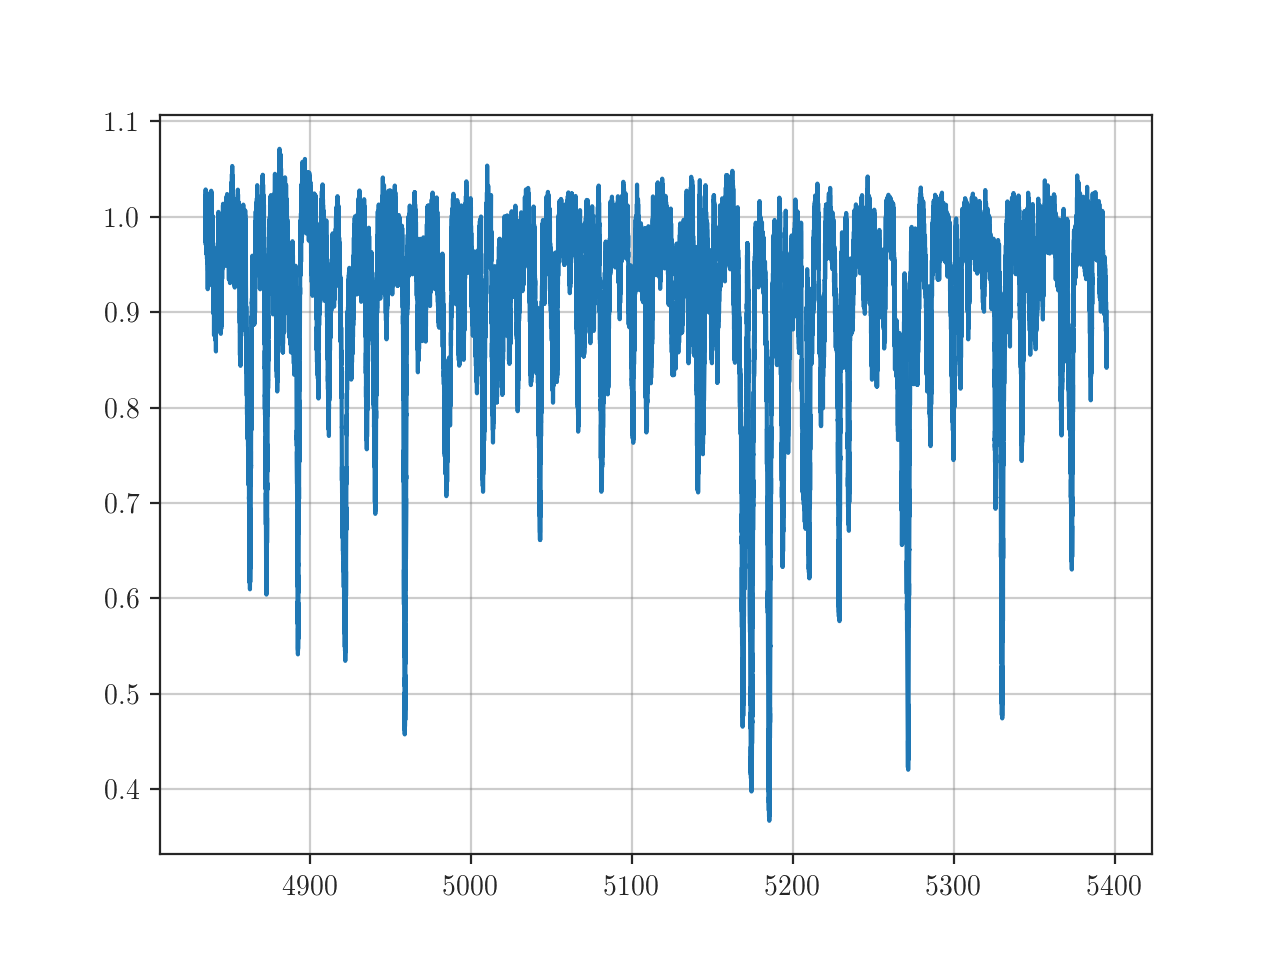

In [50]:
%matplotlib notebook
plt.plot(wave_grid, spec)

<IPython.core.display.Javascript object>


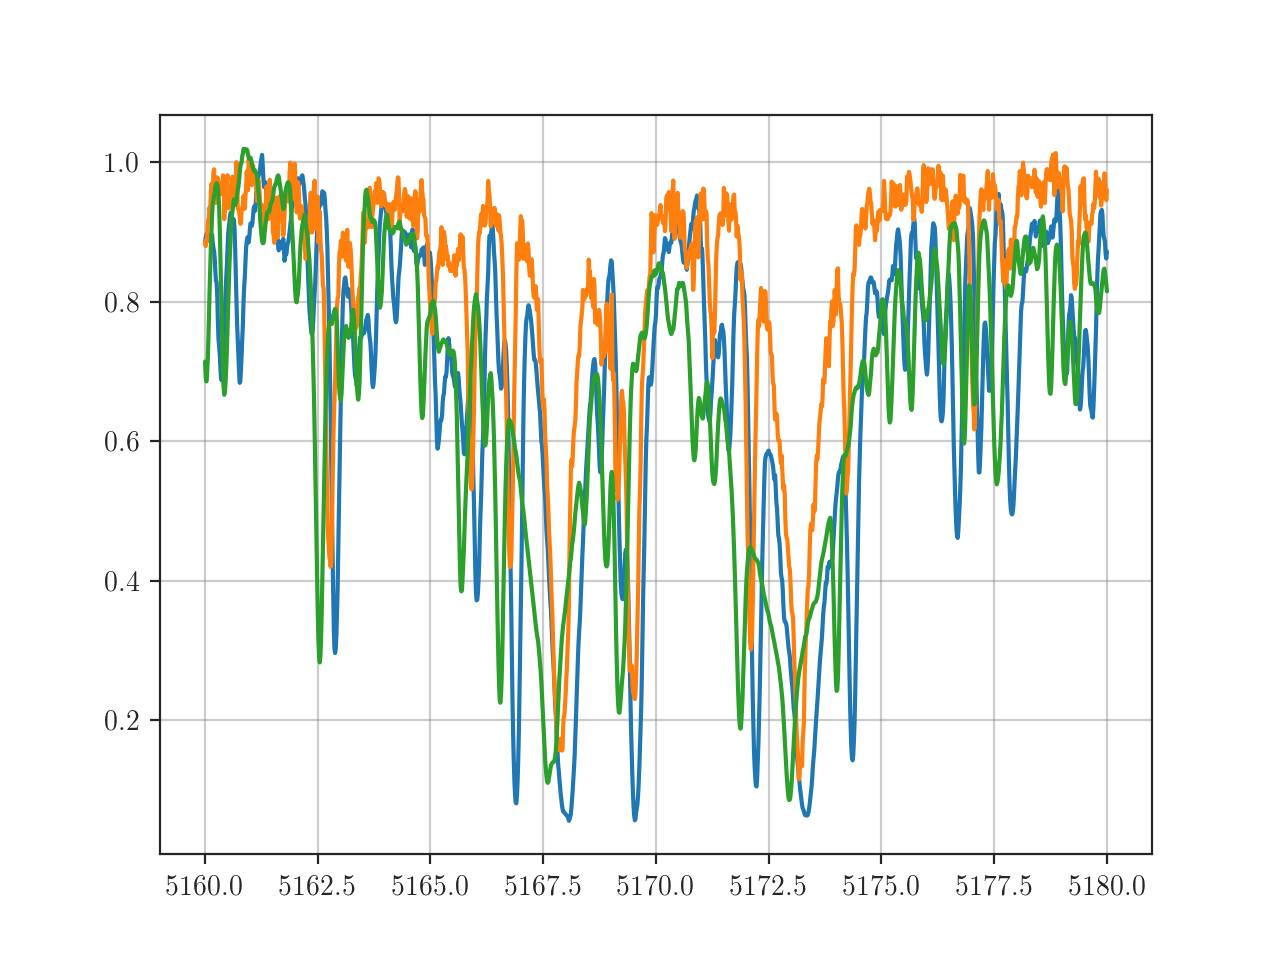

In [58]:
%matplotlib notebook
indx = (wave_grid>5160) & (wave_grid<5180)
plt.plot(wave_grid[indx], X_uves[0][indx])
plt.plot(wave_grid[indx], X_uves[1][indx])
plt.plot(wave_grid[indx], X_uves[500][indx])